<a href="https://colab.research.google.com/github/zer0Percent/Mineria-Informacion-Social/blob/T2/Mining_Social_Media_Building_and_analyzing_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Álvaro Domínguez Calvo <br>
adomingue599@alumno.uned.es

### Configuration of keywords and languages

In [ ]:
import os
import requests

import json
from datetime import date
from argparse import Namespace
import csv
import pandas as pd
import ast

Note that the API keys must be filled up in order to retrieve information.

In [ ]:

args = Namespace(
    languages = ["es", "en", "it", "de", "pt", "nl", "fr"],
    queries = ["paramore", "my chemical romance",
               "the smashing pumpkins", 
               "la palma", "dalas",
               "apple", "microsoft", "$AMC",
               "$GME", "$AAPL", "$HOOD", "$MSFT",
               "$NVDA", "$TWKS"],

    social_searcher_languages = ["es", "en", "it", "de", "pt-PT", "nl", "fr"],
    social_searcher_networks = ["reddit"],
    social_searcher_queries = ["paramore", "my chemical romance",
               "the smashing pumpkins", 
               "la palma", "dalas",
               "apple"],
    limit_social_searcher = 100,
    
    twingly_queries = ["paramore", "my chemical romance",
               "the smashing pumpkins", 
               "la palma", "dalas",
               "apple", "microsoft"],
    sorting_param = 'sort-order:asc sort:published',

    social_searcher_key = 'TBD',
    twingly_api_key = 'TBD',
    tweepy_consumer_key = 'TBD',
    tweepy_consumer_secret = 'TBD',
    tweepy_access_token = 'TBD,
    tweepy_access_token_secret = 'TBD',

    base_url_twingly_url = 'https://api.twingly.com/blog/search/api/v3/search?'
)

query_dict_lang_social_searcher = dict()
query_dict_lang = dict()
query_dict_lang_twingly = dict()

for lang in args.languages:
  query_dict_lang[lang] = args.queries

for lang in args.social_searcher_languages:
  query_dict_lang_social_searcher[lang] = args.social_searcher_queries

for lang in args.languages:
  query_dict_lang_twingly[lang] = args.twingly_queries

In [ ]:
def retrieve_posts(url):
  response = requests.get(url)
  return response

In [ ]:
def build_remove_folders(folder_paths):
  remove = []
  for folder in folder_paths:
    remove.append("rm -rf {folder_path}".format(folder_path = folder))

  return remove

In [ ]:
def execute_commands(commands):
  for command in commands:
    os.system(command)

## Retrieving information from the social networks

### Social searcher

In [ ]:

def retrieve_posts_social_searcher(args, query_dict_lang_social_searcher):

  network_param = 'network={network}&'.format(network = args.social_searcher_networks[0])
  key_param = 'key={key}'.format(key = args.social_searcher_key)
  limit_param = 'limit={limit}&'.format(limit = args.limit_social_searcher)

  dict_posts = dict()
  base_url = 'https://api.social-searcher.com/v2/search?'
  for lang, queries in query_dict_lang_social_searcher.items():
    lang_param = 'lang={lang}&'.format(lang = lang)
    for keyword in queries:

      file_name = "{query}/sc_{lang}_{date}.json".format(query = keyword, lang = lang, date=date.today())
      os.makedirs(os.path.dirname(file_name), exist_ok=True)

      query_rapam = 'q={query}&'.format(query = keyword)
      url = base_url + query_rapam + network_param + lang_param + limit_param + key_param

      response = retrieve_posts(url)
      response_json = response.json()

      with open(file_name, "w") as f:
        json.dump(response_json, f)


In [ ]:
retrieve_posts_social_searcher(args, query_dict_lang_social_searcher)

In [ ]:
today = date.today()

path_dataset_social_searcher = "/content/drive/MyDrive/{date}_reddit_social_searcher_dataset.zip".format(date = str(today))

zips = []
for query in args.social_searcher_queries:
  content_path = '/content/"{query}"/'.format(query = query)
  for lang in args.social_searcher_languages:
    file_name = "sc_{l}_{today}.json".format(l = lang, today = str(date.today()))

    source_path = content_path + file_name
    zips.append("zip {dataset} {source}".format(dataset = path_dataset_social_searcher, source = source_path))

In [ ]:
execute_commands(zips)

In [ ]:
remove = build_remove_folders_commands(args.social_searcher_queries)
execute_commands(remove)

### Twingly

In [ ]:
!pip install twingly-search

In [ ]:
import datetime

In [ ]:
def query_twingly_posts(client_query, batch_limit = None):
    
    unlimited = True if batch_limit == None else False

    batches_retrieved = 0
    while unlimited or batches_retrieved < batch_limit:

      base_query = client_query.build_query_string()

      result = client.execute_query(base_query)
      for post in result.posts:

        yield post

      if result.all_results_returned():
        print("All results retrieved for the current query and language.")
        break
      
      last_post = result.posts[len(result.posts) - 1]

      client_query.start_time = last_post.published_at

      base_query = client_query.build_query_string()

      batches_retrieved += 1
  

In [ ]:
def retrieve_twingly_posts(args, client_twingly):

  client_query = client_twingly.query()
  
  for lang, queries in query_dict_lang_twingly.items():
    lang_param = 'lang:{lang} '.format(lang = lang)
    for query in queries:
      keyword_param = '{keyword} '.format(keyword = query)
      twingly_base_query = keyword_param + lang_param + args.sorting_param

      client_query.search_query = twingly_base_query
      
      print("Retrieving blog posts in language '{lang}' for the query '{query}'".format(lang = lang, query = query))
      stream_posts = query_twingly_posts(client_query, batch_limit = 1)



      posts_lang_query = []
      for index, post in enumerate(stream_posts):
        posts_lang_query.append(post)

      json_string = json.dumps([ob.__dict__ for ob in posts_lang_query], sort_keys=True, default=str, ensure_ascii=False)

      file_name = "{query}/twingly_{lang}.json".format(query = query, lang = lang)
      os.makedirs(os.path.dirname(file_name), exist_ok=True)
      
      with open(file_name, 'w') as f:
        f.write(json_string)
        print("Saved results of '{query}' in language '{lang}'. \n".format(query = query, lang = lang))

In [ ]:
from twingly_search import Client
client = Client(api_key = args.twingly_api_key)

retrieve_twingly_posts(args, client)


In [ ]:
today = date.today()

path_dataset_twingly = "/content/drive/MyDrive/{date}_twingly_dataset.zip".format(date = str(today))

zips = []
for query in args.twingly_queries:
  content_path = '/content/"{query}"/'.format(query = query)
  for lang in args.social_searcher_languages:
    file_name = "twingly_{l}.json".format(l = lang)

    source_path = content_path + file_name
    zips.append("zip {dataset} {source}".format(dataset = path_dataset_twingly, source = source_path))

In [ ]:
execute_commands(zips)

In [ ]:
remove = build_remove_folders_commands(args.twingly_queries)
execute_commands(remove)

### TweePy

Tweepy is a Python client for the Twitter API. With a valid credentials, it is possible to retrieve tweets given a string. <br>
However, the Twitter API has some restrictions when retrieving a large amount of tweets. Due to this limitation, for each query we will only retrieve 20.000 tweets. Furthermore, a time limitation is imposed to avoid disconnections by Twitter. This limitation is justified since Twitter will reject multiples petitions executed by a host in a given short interval of time between requests. <br>
The `limit_tweets` parameter will handle the maximum tweets to retrieve. On the other hand, the `counts_to_sleep` is the count of tweets threshold to trigger a `wait` clause. The `wait` will last 5 minutes.

In [ ]:
import tweepy

auth = tweepy.OAuthHandler(args.tweepy_consumer_key, args.tweepy_consumer_secret)
auth.set_access_token(args.tweepy_access_token, args.tweepy_access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)


In [ ]:
import os
import time

def generate_tweets(query, language, limit_tweets = None, counts_to_sleep = 5000):
  csv_name_file = "{query}/{lang}.csv".format(query = query, lang = language)
  os.makedirs(os.path.dirname(csv_name_file), exist_ok=True)

  total_count = 0
  with open(csv_name_file, "a") as f:
    csv_writer = csv.writer(f)
    count = 0
    on_going_count = 0
    try:

      for tweet in tweepy.Cursor(api.search,q=query,count=100,
                            lang=language).items():

        
        csv_writer.writerow([tweet.created_at, tweet.id,
                            tweet.lang, tweet.user.id,
                            tweet.text.encode('utf-8')])
        count +=1
        total_count += 1
        on_going_count += 1

        if limit_tweets != None and total_count >= limit_tweets:
          print("{limit} tweets retrieved for the query {query} and language {lang}".format(limit=limit_tweets, query = query, lang = language))
          total_count = 0
          time.sleep(30)
          break

        if count == counts_to_sleep:
          print("{counts} tweets written. Waiting 5 minutes for another batch.".format(counts=counts_to_sleep))
          print("{total} written in total. \n Remaining: {remaining}".format(total = on_going_count, remaining = limit_tweets - on_going_count))
          time.sleep(300)
          count = 0
    except:
      print("Error when retrieving tweets for the query: '{query}' and the language '{lang}'".format(query = query, lang = language))

In [ ]:
def exclude_queries_per_language(lang, queries_to_exclude, dict_lang_queries):

  queries_lang = dict_lang_queries[lang]
  remaining_queries = [query for query in queries_lang if query not in queries_to_exclude]

  return remaining_queries

The following function retrieves the tweets for a given lang a list of queries defined in the dictionary parameter.

In [ ]:
def retrieve_tweets(dict_lang_queries, limit_tweets = None, counts_to_sleep = 5000):
  for lang, queries in dict_lang_queries.items():
    for query in queries:
      generate_tweets(query, lang, limit_tweets=limit_tweets)

The function `generate_zip_commands` will yield a list of strings representing the zip command for a given query (keyword) and language.

In [ ]:
def generate_zip_commands(path_dataset, queries, languages):
  zips = []

  for query in queries:
    content_path = "/content/'{query}'/".format(query = query)
    for lang in languages:

      file_name = "{l}.csv".format(l = lang)
      dest = content_path + file_name
      zips.append("zip {dataset} {dest}".format(dataset = path_dataset, dest = dest))

  return zips

Now we proceed to the execution of the retrieval of tweets with the queries and languages proposed.

In [ ]:
retrieve_tweets(query_dict_lang, limit_tweets=50000)

5000 tweets written. Waiting 5 minutes for another batch.
5000 written in total. 
 Remaining: 45000
5000 tweets written. Waiting 5 minutes for another batch.
10000 written in total. 
 Remaining: 40000
5000 tweets written. Waiting 5 minutes for another batch.
15000 written in total. 
 Remaining: 35000
5000 tweets written. Waiting 5 minutes for another batch.
20000 written in total. 
 Remaining: 30000
5000 tweets written. Waiting 5 minutes for another batch.
25000 written in total. 
 Remaining: 25000
5000 tweets written. Waiting 5 minutes for another batch.
30000 written in total. 
 Remaining: 20000
5000 tweets written. Waiting 5 minutes for another batch.
35000 written in total. 
 Remaining: 15000
5000 tweets written. Waiting 5 minutes for another batch.
40000 written in total. 
 Remaining: 10000
5000 tweets written. Waiting 5 minutes for another batch.
45000 written in total. 
 Remaining: 5000
50000 tweets retrieved for the query la palma and language es
5000 tweets written. Waiting 5 

Next we generate the commands to zip all the folders created by the later method. <br>
Note that you will need to activate your Google Drive folder to persist them in your Drive.

In [ ]:
today = date.today()
path_dataset = "/content/drive/MyDrive/DataSets/{date}_twitter_dataset.zip".format(date = today)
zips = generate_zip_commands(path_dataset, args.queries, args.languages)

Then we execute all the zip commands for each query (folder).

In [ ]:
execute_commands(zips)

In [ ]:
remove = build_remove_folders_commands(args.queries)
execute_commands(remove)

For certain queries, there is a high density of tweets between two short date times. This will yield a skewed dataset over one especific day under the current limitation of tweets per query (`limit_tweets` parameter). Hence, the retrieval of tweets given the query `covid` will be performed separately.

In [ ]:
dict_lang_covid = dict()
for lang in args.languages:
  dict_lang_covid[lang] = ["covid"]

retrieve_tweets(dict_lang_covid, limit_tweets=100000)

5000 tweets written. Waiting 5 minutes for another batch.
5000 written in total. 
 Remaining: 95000
5000 tweets written. Waiting 5 minutes for another batch.
10000 written in total. 
 Remaining: 90000
5000 tweets written. Waiting 5 minutes for another batch.
15000 written in total. 
 Remaining: 85000
5000 tweets written. Waiting 5 minutes for another batch.
20000 written in total. 
 Remaining: 80000
5000 tweets written. Waiting 5 minutes for another batch.
25000 written in total. 
 Remaining: 75000
5000 tweets written. Waiting 5 minutes for another batch.
30000 written in total. 
 Remaining: 70000
5000 tweets written. Waiting 5 minutes for another batch.
35000 written in total. 
 Remaining: 65000
5000 tweets written. Waiting 5 minutes for another batch.
40000 written in total. 
 Remaining: 60000
5000 tweets written. Waiting 5 minutes for another batch.
45000 written in total. 
 Remaining: 55000
5000 tweets written. Waiting 5 minutes for another batch.
50000 written in total. 
 Remainin

In [ ]:
today = date.today()
path_dataset = "/content/drive/MyDrive/{date}_twitter_dataset_covid.zip".format(date = today)
zips = generate_zip_commands(path_dataset, ["covid"], args.languages)


In [ ]:
execute_commands(zips)

In [ ]:
remove = build_remove_folders_commands(["covid"])
execute_commands(remove)

# Unifiying and processing datasets

In [ ]:
args_loading = Namespace(
    drive_base_url = "https://drive.google.com/uc?id=",
    dataset_names = ["twitter_dataset.zip", "twitter_covid_dataset.zip"],
    twitter_covid_dataset_name = "twitter_covid_dataset.zip",
    
    path_base_dataset_content = "./content/",
    url_social_searcher_dataset = "",
    url_twingly_dataset = "",
    url_tweepy_dataset = "",
    id_drives_twitter = ["102ErESGFwB108dQ6idh0QHegypVIaH4A",
                         "1-893bowy6fULT_MV2uFBKRcQqdZYfWMd",
                         "1-4MXLLGIq9c4gt5nqJPLjn9aiS5NRRJW",
                         "1-3oMrH6fsR8tyU8eJOngqm4EZJD6VX4g",
                         "1-BbQjGJNgW8-hqfdcKF56TS4DnLq_s3-",
                         "1-6XGR0avmhYSKwKWE-RuqSzESXLo7DWi",
                         "1Zp3cm9KYuxzg-m6qTpMNyb9ujBv7YXpp",
                         "1-5Kwx2g3Vaj2K1N_93Ry1Y3UbSSBaUyH",
                         "1-08xj7PH_0uh1ka3tCV__h_ur3CLJQRf",
                         "1-1Be2jAlSDPxb-dxwwlfza8z1vZrqT3o",
                         "1-3HGFAAxuzboyM2IYN2gqRO1gTd7kV_2",
                         "1--P1hPp1dsowd3HFJNdsTK4ujliyJtiA",
                         "1-6YS6bUiFWp3N4w6SlTxFXrBdB3nZe8G",
                         "1-3k2BneoYzkGciJLIaGpZznfDLlbodrU"],
 
    id_drives_covid_twitter = ["1t-Ozu3gNXInuVXxTSgfOXkjn7T1loc1f",
                               "1cH_fFOBf-tbqAQE5GWQ61PPk6jGAuITU",
                              "1-2ttckgl2sHsoow1epKWJw5iu3eNNRPL",
                               "1-7ded-JGwg5AbblEZz1p4Ok6T4Fpww85",
                               "1-FfHjKOnMYX_UV6-FZBzKJDKM-JVQf4_",
                               "1-CFULSEg4OGAQQzzF2RVoySICL6jgazW",
                               "1-3a-iCzSWYfU0CWLz0sXP6lfwIk4s6nC",
                               "1-5LkF0PkQU3fCVCnoU84iEl1ixl8xZS7",
                               "1bM1apFVnpKQ11R8uf7uA8YXA0eBwdLaG",
                               "1-9R023j00foJj5kaqJzx6l_AJ3RgIOtD",
                               "1-24sZb-3dzKFPoe-zF8F7bRl_WlD0-OV",
                               "1-05ZasG3x9kWCNfnhnD0yHM6u9egRs7h",
                               "1-FNjoU-AKT0F46qr_Q9fLHlVQM0UWAB8",
                               "1-2DCg6ys_jFOxE98Al2kSR7VPYLYKxQ6",
                               "1-33cx1vVp6ThwLqFh6EYajp56H19Sqzy",
                               "1gt7IVFondaFE39p2HjQ4bmjk3sgmc8cj",
                               "1I6kxufvv5jGh-noAthfgNbb8BxftFc8N",
                               "1rbSmrZwq_bvmGs4Nuup0Sswn41ZZsJZ6"],
    id_drives_reddit = [
                        "1-F5hXIgjMD3jZW-opqeQkPzVseWLt3Dl",
                        "1PwrLJu4cy8Xc1ExWthlthEDk3dO5kfis",
                        "1oSoxVwYSo1S2_3DTqpGnt3AujgT7GIms",
                        "1cc8G9BXuMhAwFfRURecNsoN-99izWkO0",
                        "10YzuSDxmmK47FUBVPNmee7YEHGDK8103",
                        "1Xj3mKB3kF8gqGrns0kVfecsiaux_6r2X",
                        "1OH4_YtJZWuX73aWARs5Xj_H5CeY4bv3c",
                        "1-1-8ZNPv95WIdG37W0wY5sQhgL-Mp1yh",
                        "1wc8M1ImthsEESM80HdpBm9GsF2M44iCv",
                        "1t6v3JZJNYbpT1DstEuy7oPmovquFN8jj",
                        "1wvj_MKCrSbNz_dFMPYC9u69YjHA8Hpz3",
                        "1LrKuu73164nbb-yGlEUp5-LrRfqtGKbq",
                        "1PnHcSMwiZNQn8-6AQOabbJO1F__o-_pm",
                        "1UvYxj1iA_dHfHEuYxzA088533mNDrBOk",
                        "1EopIzVSL9sPVjfq0FJrBrhKMNAJB9p2n",
                        "1sUSeh_TSX8V7KagoCyMTO9huJTJQT8hh",
                        "1-EJfe90ggYJARFKx6CloXiybG9tw7NUj",
                        "1mpqjrdipWRlc2YYHpwiVu69EOkydCylR",
                        "19iH9Mvk1KE7DzfGO1evwbxb3qHvoWhRW",
                        "1HyDDJGe_GCjaE_riiob-3q0nvjjZ9d_R"
    ],
    id_drives_twingly = [
                         "1-7Rya2AG0BapXDSYYJ2R-9r-VSNqSCEc"
    ],
    twitter_column_names = ['date', 'id_tweet', 'language', 'user_id', 'encoded_text']
)

## Download datasets from Google Drive.

The crawled data was uploaded to a personal Google Drive. In order to process and unify the data into a CSV it is mandatory to download it first. The next function build the command to download a file from Google Drive given its identifier.

In [ ]:
def down_dataset_command(args, id_drive):
  command = 'gdown {base_url}{id}'.format(base_url = args.drive_base_url, id = id_drive)
  return command

The function `unzip_dataset_commands` takes the name of the Reddit name files and generates the unzip commands for each file.

In [ ]:
def unzip_dataset_commands(datasets):
  commands = []
  for dataset in datasets:
    destiny = "./" + dataset
    commands.append('unzip -q {dataset}.zip -d {destiny}'.format(dataset = dataset, destiny = destiny))
  return commands

### Downloading Twitter data

Given a set of google drive ids, build the download command and execute them.

In [ ]:
commands = [ down_dataset_command(args_loading, id) for id in args_loading.id_drives_twitter]
execute_commands(commands)


For the `covid` query we execute the commands to download the tweets retrieved per day.

In [ ]:
commands_twitter_covid = [ down_dataset_command(args_loading, id) for id in args_loading.id_drives_covid_twitter]
execute_commands(commands_twitter_covid)

Once downloaded the datasets, proceed with unzipping them.

In [ ]:
twitter_dataset_file_names = [file_name.split('.')[0] for file_name in os.listdir('./') 
if "twitter_dataset" in file_name ]
twitter_dataset_file_names

['2021-12-15_twitter_dataset_covid',
 '2021-12-12_twitter_dataset',
 '2021-12-11_twitter_dataset_covid',
 '2021-12-19_twitter_dataset_covid',
 '2021-12-22_twitter_dataset',
 '2021-12-10_twitter_dataset_covid',
 '2021-12-10_twitter_dataset',
 '2021-12-25_twitter_dataset_covid_1',
 '2021-12-17_twitter_dataset_covid',
 '2021-12-21_twitter_dataset',
 '2021-12-20_twitter_dataset',
 '2021-12-31_twitter_dataset_covid',
 '2021-12-24_twitter_dataset',
 '2021-12-20_twitter_dataset_covid',
 '2021-12-05_twitter_dataset_covid',
 '2021-12-13_twitter_dataset_covid',
 '2021-12-08_twitter_dataset_covid',
 'twitter_dataset',
 '2021-12-29_twitter_dataset_covid',
 '2021-12-16_twitter_dataset',
 '2021-12-21_twitter_dataset_covid',
 '2021-12-28_twitter_dataset',
 '2021-12-04_twitter_dataset_covid',
 '2021-12-29_twitter_dataset',
 '2021-12-06_twitter_dataset_covid',
 '2021-12-13_twitter_dataset',
 '2021-12-07_twitter_dataset_covid',
 '2021-12-09_twitter_dataset_covid',
 '2021-12-11_twitter_dataset',
 '2021-1

In [ ]:
args_loading.dataset_names = twitter_dataset_file_names

In [ ]:
commands_unzip = unzip_dataset_commands(args_loading.dataset_names)
execute_commands(commands_unzip)

In [ ]:
zip_files = [file_name + ".zip" for file_name in twitter_dataset_file_names]
execute_commands(build_remove_folders(zip_files))

### Downloading Reddit data

We generate all the download commands given the Google Drive ids where the files are located.

In [ ]:
commands = [ down_dataset_command(args_loading, id) for id in args_loading.id_drives_reddit]
execute_commands(commands)


Next we obtain the name files related to data Reddit.

In [ ]:
reddit_datasets = [file_name.split('.')[0] for file_name in os.listdir('./')
if "reddit" in file_name]

Unzip all the Reddit compressed files.

In [ ]:
args_loading.dataset_names = reddit_datasets
commands_unzip = unzip_dataset_commands(args_loading.dataset_names)
execute_commands(commands_unzip)

### Downloading Twingly data

In [ ]:
# down_dataset_command(args_loading, id)
download_twingly_command = down_dataset_command(
    args_loading,
    args_loading.id_drives_twingly[0]
)

execute_commands([download_twingly_command])

Next, it will be decompressed the Twingly dataset.

In [ ]:
twingly_dataset_name = [filename.split('.')[0] for filename in os.listdir()
if "twingly" in filename]

unzip_command_twingly = unzip_dataset_commands(twingly_dataset_name)

execute_commands(unzip_command_twingly)

## Reading and persisting datasets

### Twitter dataset

In [ ]:
def list_files_query(base_path, query):
  return os.listdir(base_path + query)

In [ ]:
def get_paths_dataset_files(base_path, query):
  files = list_files_query(base_path, query)
  return [ base_path + query + "/" + file for file in files]

Next, each csv file will be stored for a given query. Mind that the column text must be decoded since it is stored as UTF-8.

In [ ]:
import ast
def generate_dataframe_from_csv(path_csv, column_names):
  dataframe = pd.read_csv(path_csv, names = column_names)

  #set the column text as a bytes array
  dataframe['encoded_text'] = dataframe['encoded_text'].apply(ast.literal_eval)
  dataframe['decoded_text'] = dataframe['encoded_text'].str.decode('utf-8')
  return dataframe

The next function creates a dictionary mapping the query with the data retrieved for each of them.

In [ ]:
def build_twitter_dataframe(queries, path_base_dataset_content, twitter_column_names):
  dict_query_dataframes = dict()
  for query in queries:
    path_files = get_paths_dataset_files(path_base_dataset_content, query)
    query_dataframes = [ generate_dataframe_from_csv(path_file,
                                               twitter_column_names)
                        for path_file in path_files]
    dict_query_dataframes[query] = query_dataframes

  return dict_query_dataframes


In [ ]:
def build_dict_dataset_twitter_per_folder(path_content_twitter_datasets,
                          queries,
                          column_names):
  dicts_dataframes_twitter_dataset = []
  for path_twitter_dataset in path_content_twitter_datasets:

    dict_dataframe = None
    if "covid" in path_twitter_dataset:

      dict_dataframe = build_twitter_dataframe(
          ["covid"],
          path_twitter_dataset,
          args_loading.twitter_column_names
      )
      print(dict_dataframe.keys())
    else:
      dict_dataframe = build_twitter_dataframe(
          args.queries,
          path_twitter_dataset,
          args_loading.twitter_column_names
      )
    dicts_dataframes_twitter_dataset.append(dict_dataframe)

  return dicts_dataframes_twitter_dataset


We build, for each `twitter_dataset` downloaded (unzipped folder), a dictionary $(query, \; \{ dataframe\})$, that is, for each query, build a set of dataframes that contain all the tweets for all the proposed languages. Since the Twitter dataset was built in different folders, for each folder, it will be stored a dictionary.

In [ ]:
path_content_twitter_datasets = []


for folder_name in args_loading.dataset_names:

  covid_path = ""
  if "covid" in folder_name:
    covid_path = "covid/"

  path_folder = "./" +  folder_name + "/content/"
  path_content_twitter_datasets.append(path_folder)

path_content_twitter_datasets
twitter_unmerged_dataset = build_dict_dataset_twitter_per_folder(
    path_content_twitter_datasets,
    args.queries,
    args_loading.twitter_column_names)

dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])
dict_keys(['covid'])


In [ ]:
print(path_content_twitter_datasets)

['./2021-12-20_twitter_dataset/content/', './2021-12-09_twitter_dataset_covid/content/', './2021-12-08_twitter_dataset_covid/content/', './2021-12-31_twitter_dataset_covid/content/', './2021-12-25_twitter_dataset_covid_1/content/', './2021-12-24_twitter_dataset/content/', './2021-12-10_twitter_dataset/content/', './2021-12-22_twitter_dataset/content/', './2021-12-04_twitter_dataset_covid/content/', './2021-12-13_twitter_dataset_covid/content/', './2021-12-18_twitter_dataset_covid/content/', './2021-12-29_twitter_dataset_covid/content/', './2021-12-13_twitter_dataset/content/', './2021-12-10_twitter_dataset_covid/content/', './2021-12-07_twitter_dataset_covid/content/', './twitter_dataset/content/', './2021-12-29_twitter_dataset/content/', './2021-12-17_twitter_dataset_covid/content/', './2021-12-12_twitter_dataset/content/', './2021-12-28_twitter_dataset/content/', './2021-12-16_twitter_dataset/content/', './2021-12-15_twitter_dataset_covid/content/', './2021-12-18_twitter_dataset/cont

Now, we have $n$ dictionaries, one for each Twitter dataset folder. They will be merged in one dictionary. The functions below performs this computation.

In [ ]:
def init_dict_twitter_dataset(dataset_twitter_keys):
  twitter_dict = dict()

  for key in dataset_twitter_keys:
    twitter_dict[key] = []

  return twitter_dict

In [ ]:
def get_keys_twitter_unmerged_dataset(twitter_unmerged_dataset):
  keys = []
  for dict_twitter in twitter_unmerged_dataset:
    keys_dict = dict_twitter.keys()
    keys = keys + list(keys_dict)

  return list(set(keys))

In [ ]:
def build_twitter_dataset(dicts_twitter_dataset):

  twitter_dataset_keys = get_keys_twitter_unmerged_dataset(dicts_twitter_dataset)
  twitter_dataset = init_dict_twitter_dataset(twitter_dataset_keys)
  for key in twitter_dataset.keys():

    key_dataframes = []
    for dict_twitter in dicts_twitter_dataset:

      if dict_twitter.get(key) != None:
        key_dataframes.append(dict_twitter[key])

    flatten_dataframes = [item for sublist in key_dataframes for item in sublist]
    twitter_dataset[key] = flatten_dataframes

  return twitter_dataset

In [ ]:
twitter_dataset = build_twitter_dataset(twitter_unmerged_dataset)

Let's see how `paramore` dataset query looks like. The `0` index indicates a
dataset for one of the given languages.

In [ ]:
twitter_dataset['$NVDA'][0].head(20)

,date,id_tweet,language,user_id,encoded_text,decoded_text
0,2021-12-20 03:40:06,1472773780577693701,fr,1471151463019724812,b'12/20 Watchlist \xf0\x9f\x94\xae\n$BAC 45C &...,12/20 Watchlist 🔮\n$BAC 45C &gt; 44.37 | 43P &...
1,2021-12-19 13:01:27,1472552661627162624,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 18 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 18 Dec 2021 was:\n...
2,2021-12-18 13:01:27,1472190273455276033,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 17 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 17 Dec 2021 was:\n...
3,2021-12-17 13:01:28,1471827887221268482,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 16 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 16 Dec 2021 was:\n...
4,2021-12-16 14:21:27,1471485627459944458,fr,1354887083739983874,b'RT @BigDongProfits: 12/16 Watchlist \xf0\x9f...,RT @BigDongProfits: 12/16 Watchlist 🍌🦍\n\n$PTO...
5,2021-12-16 13:01:27,1471465498047041539,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 15 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 15 Dec 2021 was:\n...
6,2021-12-16 06:01:42,1471359861191491589,fr,1366704783592206340,b'RT @BigDongProfits: 12/16 Watchlist \xf0\x9f...,RT @BigDongProfits: 12/16 Watchlist 🍌🦍\n\n$PTO...
7,2021-12-16 01:53:48,1471297475252142082,fr,1280202642581422081,b'RT @BigDongProfits: 12/16 Watchlist \xf0\x9f...,RT @BigDongProfits: 12/16 Watchlist 🍌🦍\n\n$PTO...
8,2021-12-16 01:33:14,1471292301779501056,fr,1136758696191520768,b'12/16 Watchlist \xf0\x9f\x8d\x8c\xf0\x9f\xa6...,12/16 Watchlist 🍌🦍\n\n$PTON 40c &gt; 39.25 | 3...
9,2021-12-15 23:09:42,1471256179145904132,fr,971182347499515906,b'RT @BenkielJ: - Sortie de spider man \xf0\x9...,"RT @BenkielJ: - Sortie de spider man 😍,\n- Jer..."


Next we append all the Dataframes for each query to merge all tweets regardless their language.

In [ ]:
for query, dataframes in twitter_dataset.items():
  twitter_dataset[query] = pd.concat(dataframes, ignore_index=True)

Since we can not store the text of the tweets because legal Twitter concerns, we drop the columns `encoded_text` and `decoded_text` for each query of the dictionary in order to persist the dataset information in a CSV file. It will be deleted all the duplicated tweets too.

Drop duplicate Tweets

In [ ]:
for query, dataframe in twitter_dataset.items():
  dataframe.drop_duplicates(subset="id_tweet",
                                            inplace = True)
  twitter_dataset[query] = dataframe

Next, it will be stored he filtered Twitter dataset in order to analyze it later (Analysis section).

In [ ]:
copy_raw_twitter_dataset = twitter_dataset.copy()

In [ ]:
copy_raw_twitter_dataset['$NVDA'].head(20)

,date,id_tweet,language,user_id,encoded_text,decoded_text
0,2021-12-20 03:40:06,1472773780577693701,fr,1471151463019724812,b'12/20 Watchlist \xf0\x9f\x94\xae\n$BAC 45C &...,12/20 Watchlist 🔮\n$BAC 45C &gt; 44.37 | 43P &...
1,2021-12-19 13:01:27,1472552661627162624,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 18 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 18 Dec 2021 was:\n...
2,2021-12-18 13:01:27,1472190273455276033,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 17 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 17 Dec 2021 was:\n...
3,2021-12-17 13:01:28,1471827887221268482,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 16 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 16 Dec 2021 was:\n...
4,2021-12-16 14:21:27,1471485627459944458,fr,1354887083739983874,b'RT @BigDongProfits: 12/16 Watchlist \xf0\x9f...,RT @BigDongProfits: 12/16 Watchlist 🍌🦍\n\n$PTO...
5,2021-12-16 13:01:27,1471465498047041539,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 15 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 15 Dec 2021 was:\n...
6,2021-12-16 06:01:42,1471359861191491589,fr,1366704783592206340,b'RT @BigDongProfits: 12/16 Watchlist \xf0\x9f...,RT @BigDongProfits: 12/16 Watchlist 🍌🦍\n\n$PTO...
7,2021-12-16 01:53:48,1471297475252142082,fr,1280202642581422081,b'RT @BigDongProfits: 12/16 Watchlist \xf0\x9f...,RT @BigDongProfits: 12/16 Watchlist 🍌🦍\n\n$PTO...
8,2021-12-16 01:33:14,1471292301779501056,fr,1136758696191520768,b'12/16 Watchlist \xf0\x9f\x8d\x8c\xf0\x9f\xa6...,12/16 Watchlist 🍌🦍\n\n$PTON 40c &gt; 39.25 | 3...
9,2021-12-15 23:09:42,1471256179145904132,fr,971182347499515906,b'RT @BenkielJ: - Sortie de spider man \xf0\x9...,"RT @BenkielJ: - Sortie de spider man 😍,\n- Jer..."


Drop columns

In [ ]:
columns_to_drop = ['encoded_text', 'decoded_text']

for query, dataframe in copy_twitter_dataset.items():
  dropped_dataframe =  dataframe.drop(columns_to_drop, axis = 1)
  copy_twitter_dataset[query] = dropped_dataframe
  


In [ ]:
copy_twitter_dataset

{'$AAPL':                        date             id_tweet language              user_id
 0       2021-12-24 15:39:00  1474404247055699974       en  1473391955035885568
 1       2021-12-24 15:38:32  1474404130852675597       en  1136370591517290496
 2       2021-12-24 15:37:57  1474403983762821120       en           1201654596
 3       2021-12-24 15:37:49  1474403950489047045       en  1000586849578975232
 4       2021-12-24 15:37:30  1474403871695020067       en            239026022
 ...                     ...                  ...      ...                  ...
 284284  2021-12-16 17:23:33  1471531457050984449       en           2704294333
 287452  2021-12-15 22:54:31  1471252357191188482       en  1134242134696050688
 296950  2021-12-18 21:48:08  1472322817152610307       nl  1059977742450487296
 296963  2021-12-18 15:08:41  1472222289815302151       nl  1180158980271693825
 296974  2021-12-18 12:43:57  1472185868610064384       nl   977617680818692101
 
 [98834 rows x 4 columns],
 '

Lastly, we persist the twitter dataset.

In [ ]:
path_twitter_dataset = './full_twitter_dataset'
os.mkdir(path_twitter_dataset)

For each query, it will be retrieve the dataframe that contains all the tweets in all the languages considered. Each dataframe will be stored in a csv file.

In [ ]:
for query, dataframe in copy_twitter_dataset.items():
  path_data_query = path_twitter_dataset + "/" + query + ".csv"
  dataframe.to_csv(path_data_query, encoding='utf-8')

In [ ]:
def generate_zip_commands(path_dataset, queries, languages):
  zips = []

  for query in queries:
    content_path = "/content/'{query}'/".format(query = query)
    for lang in languages:

      file_name = "{l}.csv".format(l = lang)
      dest = content_path + file_name
      zips.append("zip {dataset} {dest}".format(dataset = path_dataset, dest = dest))



Then, it will be built the commands to compress in a zip file all the csv files.

In [ ]:
queries = args.queries + ["covid"]
path_drive_twitter_dataset = "/content/drive/MyDrive/{date}_full_twitter_dataset.zip".format(date = date.today())

commands = []
for query in queries:
  file_name = "'{query}'.csv".format(query = query)
  path_csv_file = path_twitter_dataset + "/" + file_name
  commands.append("zip {dest} {origin}".format(dest = path_drive_twitter_dataset,
                                                origin = path_csv_file))


In [ ]:
execute_commands(commands)

In [ ]:
args_loading.dataset_names

It will be removed all the folders and zips created in this process.

In [ ]:
remove_twitter_folders = build_remove_folders(args_loading.dataset_names)
remove_twitter_zip_folders = build_remove_folders([folder + ".zip" for folder in args_loading.dataset_names])
execute_commands(remove_twitter_folders)
execute_commands(remove_twitter_zip_folders)

In [ ]:
copy_twitter_dataset = None

### Reddit dataset

Each .zip downloaded contains information for each query. In order to read the content of each query as a JSON the next function will return a list of JSON objects. Mind that the properties that will be considered per instance are: <br>



*   `lang`
*   `posted`. It contains the post date.
*   `postid`. Identifier of the post
*   `sentiment`. The polarity of the post.
*   `text`. The textual post's textual information.
*   `popularity`. Nested property that contains the number of ups and comments of the post.
*   `user`. Nested property that contains information about the user.





In [ ]:
def get_posts_processed(posts):

  processed_posts = []
  for post in posts:
    processed_post = {}
    #not nested properties
    processed_post['lang'] = post.get('lang')
    processed_post['date_posted'] = post.get('posted')
    processed_post['post_id'] = post.get('postid')
    processed_post['sentiment'] = post.get('sentiment')
    processed_post['text'] = post.get('text')
    

    # process popularity nested object
    popularity = post['popularity']
    ups = popularity[0]
    comments = popularity[1]

    processed_post['ups'] = ups['count']
    processed_post['comments'] = comments['count']

    # process user info
    user_info = post['user']

    processed_post['user_name'] = user_info['name']
    processed_post['user_id'] = user_info['userid']
    processed_post['user_url'] = user_info['url']

    processed_posts.append(processed_post)

  return processed_posts

Next, it will be read all the Reddit information. Per query it will be stored a list of JSON objects returned by the `get_posts_processed` function.

In [ ]:
# # Opening JSON file
# ./reddit_dataset[i]/content/{query}/.json
dict_query_posts = {} # dict to map a query with the posts associated to it.

#initialize the dictionary with empty lists

for query in args.social_searcher_queries:
  dict_query_posts[query] = []

for reddit_dataset in reddit_datasets:
  for query in args.social_searcher_queries:

    content_folder_path = './{reddit_dataset}/content/{query}/'.format(
        reddit_dataset = reddit_dataset,
        query = query
    )
    files = os.listdir(content_folder_path)


    query_posts = []
    for reddit_file in files:
      file_path = content_folder_path + reddit_file
      with open(file_path, encoding='utf-8') as f:

        data_file = json.load(f)
        if data_file.get('posts') != None:
          posts_processed = get_posts_processed(data_file['posts'])
          query_posts = query_posts + posts_processed
        
    dict_query_posts[query] = query_posts

The number of posts per query is shown below

In [ ]:
lenghts_reddit_query = {}
list_lengths = []
for query in args.social_searcher_queries:
  lenghts_reddit_query[query] = len(dict_query_posts[query])

posts_per_query_pd = pd.DataFrame([lenghts_reddit_query])

In [ ]:
dt = posts_per_query_pd.transpose()

dt.rename(columns={0: '#instances'})

,#instances
paramore,700
my chemical romance,700
the smashing pumpkins,700
la palma,700
dalas,700
apple,700


In [ ]:
print(dt.to_latex())

\begin{tabular}{lr}
\toprule
{} &    0 \\
\midrule
paramore              &  700 \\
my chemical romance   &  700 \\
the smashing pumpkins &  700 \\
la palma              &  700 \\
dalas                 &  700 \\
apple                 &  700 \\
\bottomrule
\end{tabular}



Next, it will be stored the Reddit dataset in CSV files. A file per query.

In [ ]:
path_reddit_dataset = './full_reddit_dataset'
os.mkdir(path_reddit_dataset)

In [ ]:
for query in args.social_searcher_queries:
  csv_path_reddit = path_reddit_dataset + "/{query}.csv".format(query = query)
  dataframe_query = pd.DataFrame(dict_query_posts[query])
  dataframe_query.to_csv(csv_path_reddit, encoding='utf-8')

Lastly, it will be compressed the Reddit dataset and uploaded to Google Drive.

In [ ]:
path_drive_twitter_dataset = "/content/drive/MyDrive/{date}_full_reddit_dataset.zip".format(date = date.today())

commands = []
for query in args.social_searcher_queries:
  file_name = "'{query}'.csv".format(query = query)
  path_csv_file = path_reddit_dataset + "/" + file_name
  commands.append("zip {dest} {origin}".format(dest = path_drive_twitter_dataset,
                                                origin = path_csv_file))

In [ ]:
execute_commands(commands)

Then, it will be deleted all the Reddit information.

In [ ]:
zips_to_remove = [zip for zip in os.listdir('./') if zip.endswith('.zip')]
reddit_to_remove = [filename for filename in os.listdir('./') if "reddit" in filename and not filename.endswith('.zip')]

remove_zips_reddit = build_remove_folders(zips_to_remove)
remove_reddit_folders = build_remove_folders(reddit_to_remove)

execute_commands(remove_zips_reddit)
execute_commands(remove_reddit_folders)

In [ ]:
remove_reddit_folders

['rm -rf full_reddit_dataset',
 'rm -rf 2021-12-18_reddit_social_searcher_dataset',
 'rm -rf 2021-12-14_reddit_social_searcher_dataset',
 'rm -rf 2021-12-24_reddit_social_searcher_dataset',
 'rm -rf 2021-12-11_reddit_social_searcher_dataset',
 'rm -rf 2021-12-12_reddit_social_searcher_dataset',
 'rm -rf 2021-12-19_reddit_social_searcher_dataset',
 'rm -rf 2021-12-15_reddit_social_searcher_dataset',
 'rm -rf 2021-12-03_reddit_social_searcher_dataset',
 'rm -rf 2021-12-21_reddit_social_searcher_dataset',
 'rm -rf 2021-12-07_reddit_social_searcher_dataset',
 'rm -rf 2021-12-17_reddit_social_searcher_dataset',
 'rm -rf 2021-12-29_reddit_social_searcher_dataset',
 'rm -rf 2021-12-06_reddit_social_searcher_dataset',
 'rm -rf 2021-12-08_reddit_social_searcher_dataset',
 'rm -rf 2021-12-05_reddit_social_searcher_dataset',
 'rm -rf 2021-12-09_reddit_social_searcher_dataset',
 'rm -rf 2021-12-04_reddit_social_searcher_dataset',
 'rm -rf 2021-12-20_reddit_social_searcher_dataset',
 'rm -rf 2021-1

### Twingly dataset

It will be read all the posts for each languague and query.

First it will be retrieved the folder name that contains the Twingly dataset

In [ ]:
twingly_folder_name = [folder for folder in os.listdir('./')
if "twingly" in folder and not folder.endswith('.zip')][0]

In [ ]:
dict_query_twingly_posts = {}

#Intialize the dictionary
for query in args.twingly_queries:
  dict_query_twingly_posts[query] = []

base_path_twingly = './' + twingly_folder_name
for query in args.twingly_queries:
  query_content_path = base_path_twingly + '/content/{query}/'.format(
      query = query
  )
  # list all the files contained in query_content path
  list_twingly_files = os.listdir(query_content_path)

  # read them as a JSON file

  query_content = []
  for file_name in list_twingly_files:
    twingly_path_file = query_content_path + file_name
    with open(twingly_path_file, encoding='utf-8') as f:
      read_file = json.load(f)
      query_content = query_content + read_file
  
  dict_query_twingly_posts[query] = query_content


Then, for each query, it will be generated a CSV file containing all the posts regardless their language.

In [ ]:
path_twingly_dataset = './full_twingly_dataset'
os.mkdir(path_twingly_dataset)

In [ ]:
for query in args.twingly_queries:
  #retrieve the JSON objects per query
  twingly_posts = dict_query_twingly_posts[query]
  pd_twingly_posts = pd.DataFrame(twingly_posts)

  path_twingly_file = path_twingly_dataset + "/{query}.csv".format(
      query = query
  )
  pd_twingly_posts.to_csv(path_twingly_file, encoding='utf-8')

Then we zip the folder and store it in Google Drive

In [ ]:
path_drive_twingly_dataset = "/content/drive/MyDrive/{date}_full_twingly_dataset.zip".format(date = date.today())

commands = []
for query in args.twingly_queries:
  file_name =  "'{query}'.csv".format(query = query)
  path_csv_file = path_twingly_dataset + "/" + file_name
  commands.append("zip {dest} {origin}".format(dest = path_drive_twingly_dataset,
                                                origin = path_csv_file))

In [ ]:
execute_commands(commands)

Then, the Twingly information will be deleted.

In [ ]:
zips_to_remove = [zip for zip in os.listdir('./') if zip.endswith('.zip')]
twingly_to_remove = [filename for filename in os.listdir('./') if "twingly" in filename and not filename.endswith('.zip')]

remove_zips_twingly = build_remove_folders(zips_to_remove)
remove_twingly_folders = build_remove_folders(twingly_to_remove)

execute_commands(remove_zips_twingly)
execute_commands(remove_twingly_folders)

In [ ]:
pd.read_csv('/content/full_twingly_dataset/the smashing pumpkins.csv', encoding='utf-8')  

,Unnamed: 0,DEFAULT_DATE,author,authority,blog_id,blog_name,blog_rank,blog_url,coordinates,id,images,indexed_at,inlinks_count,language_code,latitude,links,location_code,longitude,published_at,reindexed_at,tags,text,title,url
0,0,1970-01-01 00:00:00+00:00,Mirko Mr Montag Madau,0,17922558334214612742,#ONERECORDADAY,1,https://365dischiradiomontag.wordpress.com,{},14623952874342664386,[],2021-10-27 10:12:55+00:00,0,it,NaN,[],NaN,NaN,2021-10-27 04:54:00+00:00,2021-10-27 10:12:55+00:00,"['1995', 'smashing pumpkins', 'alan moulder', ...","1995\n\n\n\n\n\n\n\n\n\n\n\nEnorme, eccessivo,...",300 – Mellon Collie and the Infinite Sadness,https://365dischiradiomontag.wordpress.com/202...
1,1,1970-01-01 00:00:00+00:00,Federico Guarducci,89,11583853353941368332,IndieForBunnies,5,http://www.indieforbunnies.com,{},11743741869394874839,[],2021-10-30 08:16:29+00:00,0,it,NaN,[],jp,NaN,2021-10-30 08:16:29+00:00,2021-10-30 08:16:29+00:00,"['Focus', 'RUBRICHE', 'celebration', 'The Nati...","“The National”, l’album omonimo ed esordio uff...",Oggi “The National” dei The National compie 20...,http://www.indieforbunnies.com/2021/10/30/oggi...
2,2,1970-01-01 00:00:00+00:00,0371musicpress,2,2898744963366580992,AscoltalamusicA,1,https://ascoltalamusica.wordpress.com,{},6369755254586654465,[],2021-11-11 02:05:59+00:00,0,it,NaN,"['https://www.facebook.com/dexilcantautore', '...",NaN,NaN,2021-11-09 06:18:00+00:00,2021-11-11 02:05:59+00:00,['ARTICOLI'],"Ciao Dex, benvenuto su Ascoltalamusica! Puoi p...",Vivere la vita senza maschere: ce ne parla Dex...,https://ascoltalamusica.wordpress.com/2021/11/...
3,3,1970-01-01 00:00:00+00:00,joyello,19,2968172681998887105,https://fardrock.wordpress.com/feed/,3,https://fardrock.wordpress.com,{},4317947968341720420,[],2021-11-10 17:03:17+00:00,0,it,NaN,['http://www.joyello.net/fardrock/melloncollie...,fr,NaN,2021-11-10 07:00:00+00:00,2021-11-10 17:03:17+00:00,"['Fard Rock Classic', '1995', 'Anniversario', ...",Artista: The Smashing Pumpkins \nEtichetta: Vi...,Fard Rock Classic: Mellon Collie And The Infin...,https://fardrock.wordpress.com/2021/11/10/fard...
4,4,1970-01-01 00:00:00+00:00,Antonio Galietta,0,13137558734839589547,Indie in the Jar,1,https://indieinthejar.rocks,{},2499715639898116277,[],2021-11-11 15:11:39+00:00,0,it,NaN,[],nl,NaN,2021-11-11 10:41:33+00:00,2021-11-11 15:11:39+00:00,"[""Il Settimo Giorno fu Rock 'N' Roll"", 'The La...",1962 – Frank Ifield era alla n.1 della classif...,11 novembre…e il settimo giorno fu Rock ‘n’ Roll!,https://indieinthejar.rocks/11-novembree-il-se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,1970-01-01 00:00:00+00:00,El Clemente Inglés,0,15330792046940583023,El Clemente Inglés,1,https://elclementeingles.blogspot.com/,{},15534853043664756372,[],2021-12-02 09:32:14+00:00,0,es,NaN,[],es,NaN,2021-12-02 07:00:00+00:00,2021-12-02 09:32:14+00:00,['Lyrics'],"- Tonight, Tonight - The Smashing Pumpkins ...","JUEVES - LYRICS (""Tonight, Tonight - The Smash...",https://elclementeingles.blogspot.com/2021/12/...
997,997,1970-01-01 00:00:00+00:00,El Clemente Inglés,1,16884185344585041390,El Clemente Inglés,1,http://elclementeingles.blogspot.com,{},16588313958634026993,[],2021-12-02 12:02:12+00:00,0,es,NaN,[],es,NaN,2021-12-02 07:00:00+00:00,2021-12-02 12:02:12+00:00,['Lyrics'],"- Tonight, Tonight - The Smashing Pumpkins ...","JUEVES - LYRICS (""Tonight, Tonight - The Smash...",http://elclementeingles.blogspot.com/2021/12/j...
998,998,1970-01-01 00:00:00+00:00,EL MAESTRO,5,5641312661665639127,El maestro,1,https://elmaestrocompentente.blogspot.com/,{},8154939443996201563,[],2021-12-03 05:08:14+00:00,0,es,NaN,['https://blogger.googleusercontent.com/img/a/...,jp,NaN,2021-12-03 05:04:00+00:00,2021-12-03 05:08:14+00:00,[],Efemérides Mexicanas Diciembre 02Dr. Héctor Da...,Efemérides Mexicanas 2021 Diciembre 02,https://elmaestrocompentente.blogspot.com/2021...
999,999,1970-01-01 00:00:00+00:00,EL MAESTRO,0,4864522485929689602,Efemérides M

#  Data Analysis

First it will downloaded and decompressed the three datasets. 

In [ ]:
full_datasets = Namespace(
    id_twitter_dataset = "1-5eiJwqAH-g36sVsAeq77U4Jpbqp-6TD",
    id_twingly_dataset = "1-2LUSueU6V9vtfQ8b5ApaK-SFbT_DFhS",
    id_reddit_dataset = "1-6opQ3jD2lkoluyfoTMoCidcQqZfw_pL",
    dataset_names = ["twitter", "twingly", "reddit"]
)

In [ ]:
down_command_twitter = down_dataset_command(args_loading, full_datasets.id_twitter_dataset)
down_command_twingly = down_dataset_command(args_loading, full_datasets.id_twingly_dataset)
down_command_reddit = down_dataset_command(args_loading, full_datasets.id_reddit_dataset)

commands_down = [down_command_twitter,
                 down_command_twingly,
                 down_command_reddit
                 ]

In [ ]:
execute_commands(commands_down)

In [ ]:
dataset_names = [dataset.split('.')[0] for dataset in os.listdir('./') if "dataset" in dataset and "full" in dataset]
commands_unzip_full_datasets = unzip_dataset_commands(dataset_names)

In [ ]:
commands_unzip_full_datasets

['unzip -q 2022-01-04_full_twitter_dataset.zip -d ./2022-01-04_full_twitter_dataset',
 'unzip -q 2022-01-14_full_reddit_dataset.zip -d ./2022-01-14_full_reddit_dataset',
 'unzip -q 2022-01-11_full_twingly_dataset.zip -d ./2022-01-11_full_twingly_dataset']

In [ ]:
execute_commands(commands_unzip_full_datasets)

Next, it will be stored all the CSV y different DataFrames.

In [ ]:
dataset_name_folders = [dataset.split('.')[0] for dataset in os.listdir('./') if "dataset" in dataset and "full" in dataset and ".zip" not in dataset]
print(dataset_name_folders)

['2022-01-04_full_twitter_dataset', '2022-01-11_full_twingly_dataset', '2022-01-14_full_reddit_dataset']


In [ ]:

dict_dataset_dataframe = {}
dict_entity_dataframe = {}
for dataset in dataset_name_folders:
  dict_dataset_dataframe[dataset] = None

for dataset in dataset_name_folders:
  base_path_dataset = './{dataset}'.format(dataset = dataset)
  subfolder_dataset = os.listdir(base_path_dataset + '/')[0]
  base_path_dataset = base_path_dataset + '/' + subfolder_dataset

  csv_file_names = os.listdir(base_path_dataset)

  # read all the csv for the given dataset
  dataframes_per_entity = []
  dataset_dataframes = []
  for csv in csv_file_names:
    csv_path = base_path_dataset + '/{csv}'.format(csv = csv)
    with open(csv_path, 'r', encoding='utf-8') as csv_file:
      csv_dataframe = pd.read_csv(csv_file, encoding='utf-8', )

      dataframes_per_entity.append((csv.split('.')[0], csv_dataframe))
      dataset_dataframes.append(csv_dataframe)

    
  dict_entity_dataframe[dataset] = dataframes_per_entity
  dict_dataset_dataframe[dataset] = pd.concat(dataset_dataframes, ignore_index=True)

The datasets stored in memory are

In [ ]:
dict_entity_dataframe.keys()

dict_keys(['2022-01-04_full_twitter_dataset', '2022-01-11_full_twingly_dataset', 'raw_2022-01-17_full_twitter_dataset', '2022-01-14_full_reddit_dataset'])

## Data analysis at dataset level

Storing all the datasets

Twitter dataset

In [ ]:
twitter_dataset = dict_dataset_dataframe['2022-01-04_full_twitter_dataset']
twitter_dataset['date'] = twitter_dataset['date'].apply(lambda x: x[0:10])
twitter_dataset['date'] = pd.to_datetime(twitter_dataset["date"])
twitter_dataset.head(2)

,Unnamed: 0,date,id_tweet,language,user_id
0,0,2021-12-24,1474418195398332444,en,1454082428671250440
1,1,2021-12-24,1474418036539260928,en,1353011001680039937


**Twitter dataset with textual information**

In [ ]:
twingly_dataset = dict_dataset_dataframe['2022-01-11_full_twingly_dataset']
twingly_dataset["published_at"] = twingly_dataset["published_at"].apply(lambda x: x[0:10])
twingly_dataset["published_at"] = pd.to_datetime(twingly_dataset["published_at"])
twingly_dataset.head(2)

,Unnamed: 0,DEFAULT_DATE,author,authority,blog_id,blog_name,blog_rank,blog_url,coordinates,id,images,indexed_at,inlinks_count,language_code,latitude,links,location_code,longitude,published_at,reindexed_at,tags,text,title,url
0,0,1970-01-01 00:00:00+00:00,NaN,0,6286472496544584652,querencia,1,https://escapadeist.tumblr.com/,{},12493040865883443225,[],2021-11-25 15:52:33+00:00,0,de,NaN,['https://beaulionet.tumblr.com/post/647696450...,NaN,NaN,2021-11-25,2021-11-25 15:52:33+00:00,"['heck yeah', 'paramore', 'hayley williams']",beaulionet: NEW MILF JUST DROPPED,NaN,https://escapadeist.tumblr.com/post/6688364802...
1,1,1970-01-01 00:00:00+00:00,Doctorrocksite,0,9958143276602002215,DOCTOR ROCK,1,https://thedoctorrocksite.wordpress.com,{},13045665604403067302,[],2021-11-29 18:57:31+00:00,0,de,NaN,[],NaN,NaN,2021-11-29,2021-11-29 21:19:22+00:00,"['NEWS', 'HAYLEY WILLIAMS', 'PARAMORE']",ELLA SE BURLA…ELLA SE RÍE…PERO LA IDEA YA ESTÁ...,HAYLEY ’ S COMEBACK ?,https://thedoctorrocksite.wordpress.com/2021/1...


In [ ]:
reddit_dataset = dict_dataset_dataframe['2022-01-14_full_reddit_dataset']

reddit_dataset["date_posted"] = reddit_dataset["date_posted"].apply(lambda x: x[0:10])
reddit_dataset["date_posted"] = pd.to_datetime(reddit_dataset["date_posted"])
reddit_dataset.head(2)

,Unnamed: 0,lang,date_posted,post_id,sentiment,text,ups,comments,user_name,user_id,user_url
0,0,en,2021-12-06,r9xyky,neutral,"BBC 1 Live Lounge Performance [flac] Hi, recen...",16,3,coolcoolnodoubt,coolcoolnodoubt,http://www.reddit.com/user/coolcoolnodoubt
1,1,en,2021-12-06,r9unna,neutral,New Synth Pop/Rock Band Hey y’all! New synth p...,4,0,benbensmith3,benbensmith3,http://www.reddit.com/user/benbensmith3


### Number of posts of each social media

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
def parse_dataset_name(name):
  no_date = name[16:]
  result = no_date.split('_')[0].capitalize()
  return result

In [ ]:

# create a dict per attribute to analyze
attribute_data = dict()
indexes = ["#posts"]

# retrieving #posts
shapes = dict()
for name, dataset in dict_dataset_dataframe.items():
  shape_dataset = dataset.shape

  parsed_name = parse_dataset_name(name)
  shapes[parsed_name] = shape_dataset[0]

attribute_data["#posts"] = shapes


In [ ]:
posts_dataframe = pd.DataFrame(data=attribute_data['#posts'], columns=shapes.keys(), index=['#posts']).transpose()

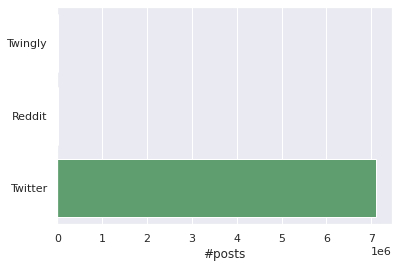

In [ ]:
sns.barplot(data=posts_dataframe, x='#posts', y=posts_dataframe.index)

### Number of posts for each language and social media

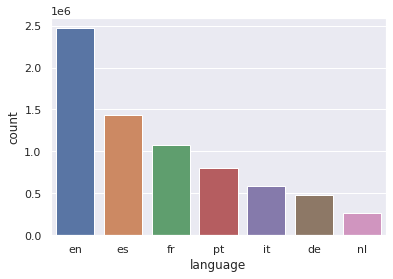

In [ ]:


count_lang_twitter = sns.countplot(x="language", data=twitter_dataset, order=twitter_dataset['language'].value_counts().index)


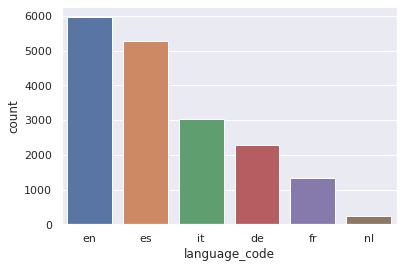

In [ ]:
count_lang_twingly = sns.countplot(x="language_code", data=twingly_dataset, order=twingly_dataset['language_code'].value_counts().index)

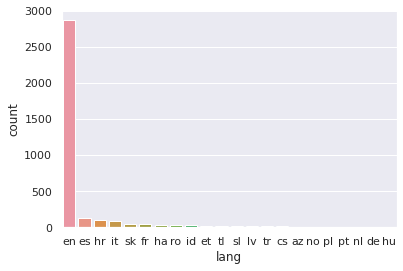

In [ ]:
count_lang_reddit = sns.countplot(x="lang", data=reddit_dataset, order=reddit_dataset['lang'].value_counts().index)

### Number of posts per day

In [ ]:
sns.set(rc={'figure.figsize':(20.7,8.27)})

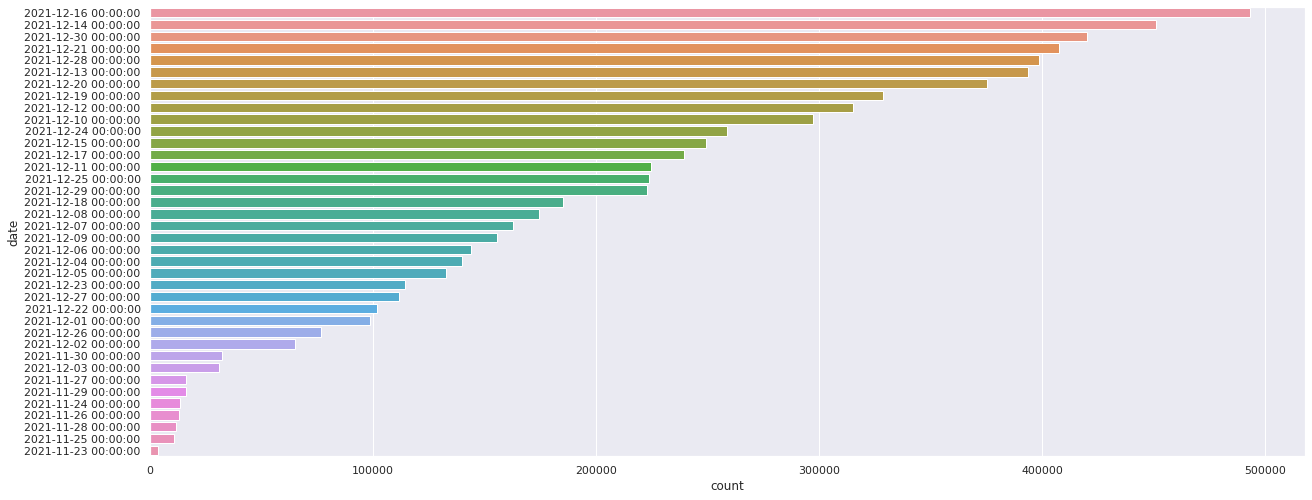

In [ ]:
count_lang_twitter = sns.countplot(y="date", data=twitter_dataset, order=twitter_dataset['date'].value_counts().index)

In [ ]:
print(min(twingly_dataset['published_at']))
print(max(twingly_dataset['published_at']))

2020-11-09 00:00:00
2021-12-06 00:00:00


In [ ]:
sns.set(rc={'figure.figsize':(20.7,80.27)})

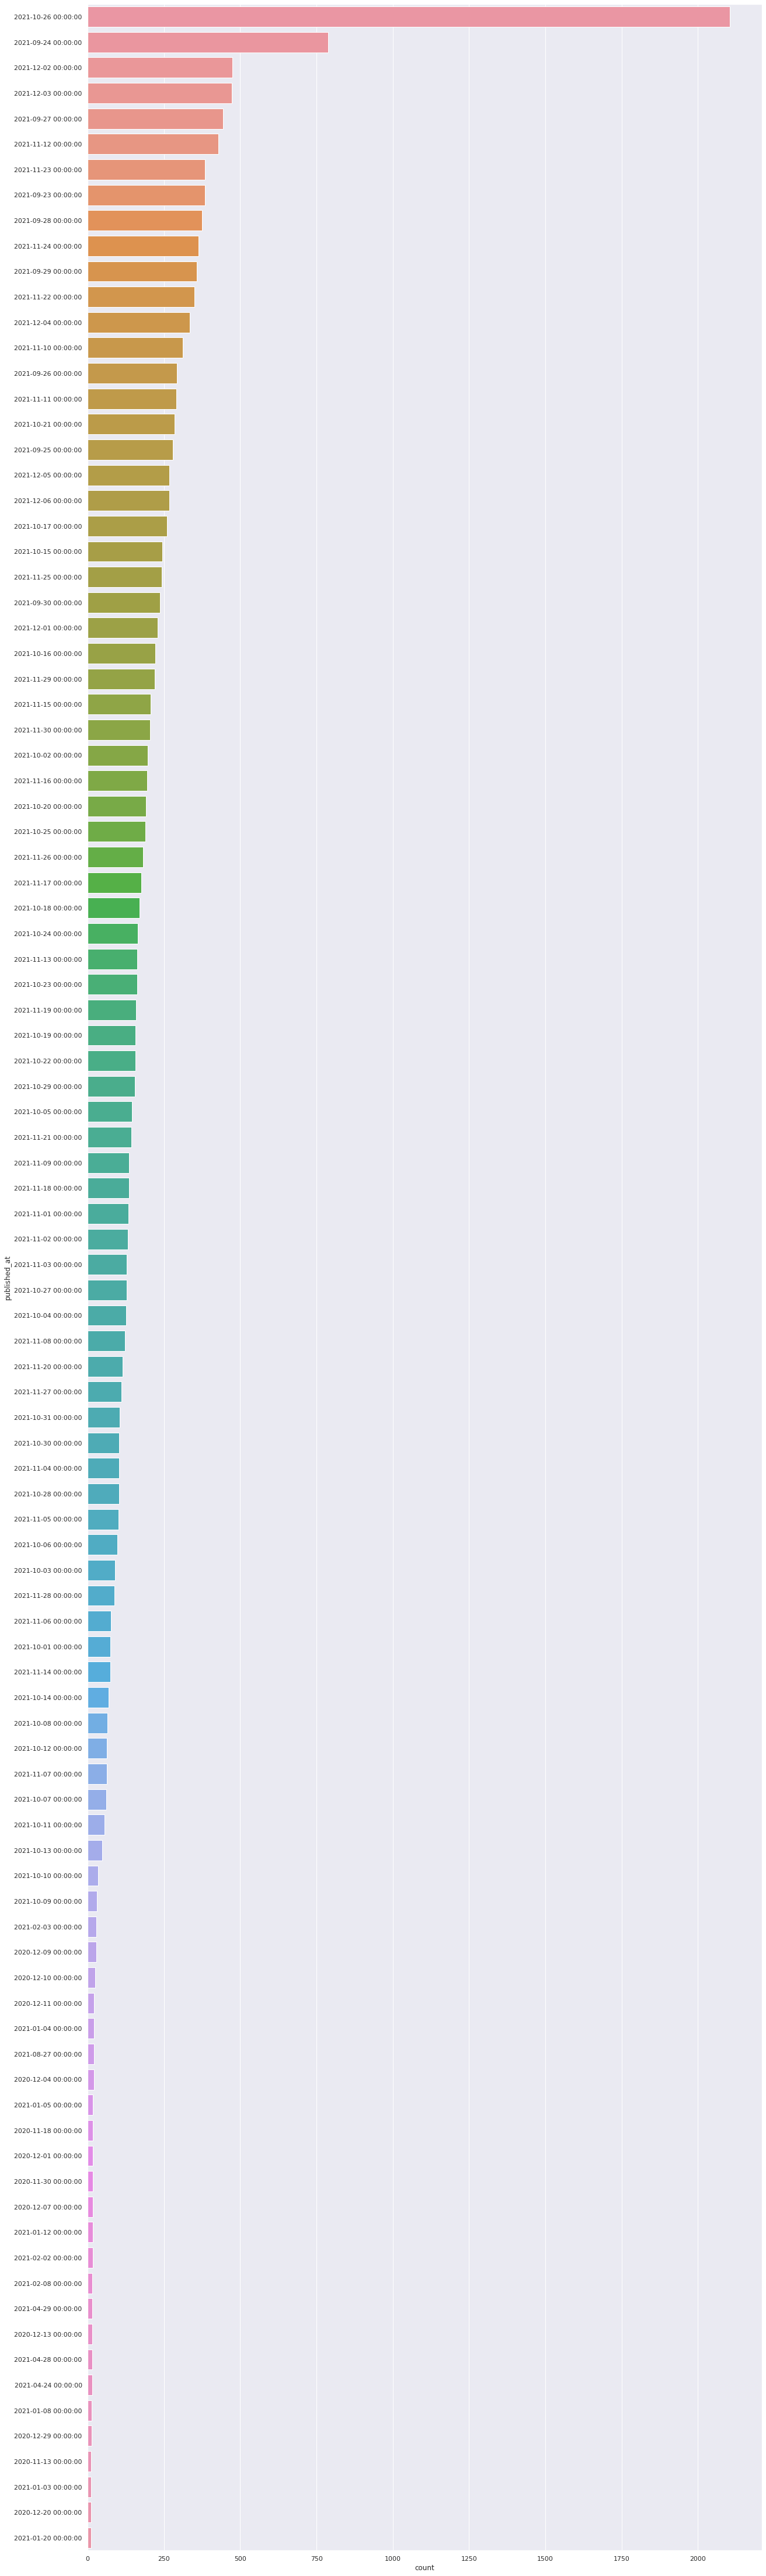

In [ ]:
count_lang_twingly = sns.countplot(y="published_at", data=twingly_dataset, order=twingly_dataset['published_at'].value_counts().iloc[:100].index)

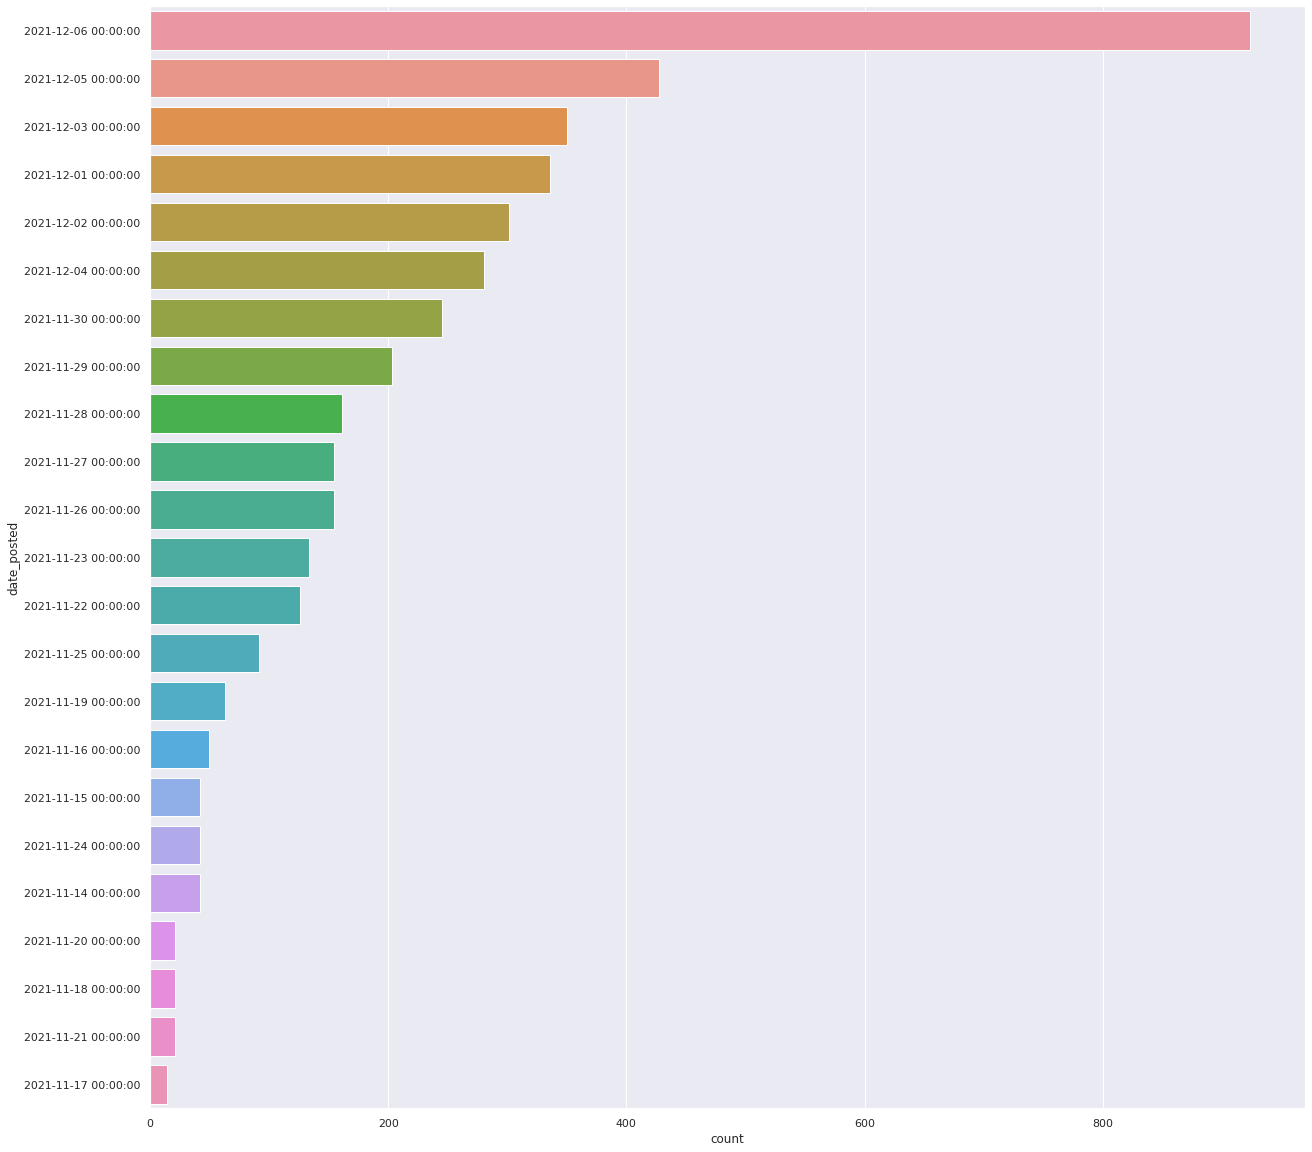

In [ ]:
count_lang_reddit = sns.countplot(y="date_posted", data=reddit_dataset, order=reddit_dataset['date_posted'].value_counts().index)

## Data analysis at named entity level

###Twitter dataset

In [ ]:
copy_raw_twitter_dataset['$NVDA'].head(20)

,date,id_tweet,language,user_id,encoded_text,decoded_text
0,2021-12-12 17:18:59,1470080757179822089,fr,1432762383781478402,b'$NVDA consolidation autour de 300. Pourrait ...,$NVDA consolidation autour de 300. Pourrait of...
1,2021-12-12 16:47:01,1470072709858140169,fr,49621897,b'S09\n\xc3\x87a remonte mais c\xe2\x80\x99est...,S09\nÇa remonte mais c’est calme\nTop:\n$LCID ...
2,2021-12-12 13:01:28,1470015947427745797,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 11 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 11 Dec 2021 was:\n...
3,2021-12-11 13:01:27,1469653559037808647,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 10 Dec 2021 was:...,$NVDA\nTwitter Sentiment on 10 Dec 2021 was:\n...
4,2021-12-10 16:09:54,1469338592241537025,fr,933102406711222276,"b""D\xc3\xa9but de position achet\xc3\xa9 sur #...","Début de position acheté sur #NVDIA, $NVDA. C'..."
5,2021-12-10 15:58:19,1469335679696003074,fr,710142745671802880,"b""@France24_fr Moi qui venait d'acheter du $MS...",@France24_fr Moi qui venait d'acheter du $MSFT...
6,2021-12-10 14:42:53,1469316697559556104,fr,925751546159169536,b'Pre-Market Movers \rhttps://t.co/f5pQyfdDFB...,Pre-Market Movers \rhttps://t.co/f5pQyfdDFB \...
7,2021-12-10 13:01:27,1469291169523896331,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 9 Dec 2021 was:\...,$NVDA\nTwitter Sentiment on 9 Dec 2021 was:\n▒...
8,2021-12-09 13:01:28,1468928783839371269,fr,1218312549973680128,b'$NVDA\nTwitter Sentiment on 8 Dec 2021 was:\...,$NVDA\nTwitter Sentiment on 8 Dec 2021 was:\n▒...
9,2021-12-09 11:15:40,1468902159978622979,fr,1343870001581682688,b'RT @hamiibands: 12/9/2021 WatchList:\n\n- $S...,RT @hamiibands: 12/9/2021 WatchList:\n\n- $SQ ...


In [ ]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

False

In [ ]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

twitter_dataframes_per_query = []
columns_twitter = ["lang", "is_rt", "has_link", "#links", "hashtag_containing_named_entity",
                   "#hashtags", "query", "tweet_tokenized" ]
for query, dataframe in copy_raw_twitter_dataset.items():

  query_dataframe = pd.DataFrame(columns=columns_twitter)

  query_dataframe['tweet_tokenized'] = dataframe['decoded_text'].apply(lambda x: tknzr.tokenize(x))
  query_dataframe['is_rt'] = query_dataframe['tweet_tokenized'].apply(lambda x: "RT" in x)
  query_dataframe['has_link'] = query_dataframe['tweet_tokenized'].apply(lambda x: any("http" in s for s in x))
  query_dataframe['#links'] = query_dataframe['tweet_tokenized'].apply(lambda x: len([token for token in x if "http" in token]))
  query_dataframe['#hashtags'] = query_dataframe['tweet_tokenized'].apply(lambda x: len([token for token in x if token.startswith("#")]))
  query_dataframe['hashtag_containing_named_entity'] = query_dataframe['tweet_tokenized'].apply(lambda x: any(query in hashtag for hashtag in [token for token in x if token.startswith("#")]))

  query_dataframe['lang'] = dataframe['language']

  query_dataframe = query_dataframe.assign(query=query)
  twitter_dataframes_per_query.append(query_dataframe)

In [ ]:
twiiter_raw_full_dataframe = pd.concat(twitter_dataframes_per_query, ignore_index=True)

In [ ]:
twiiter_raw_full_dataframe.iloc[5000:10000]

,lang,is_rt,has_link,#links,hashtag_containing_named_entity,#hashtags,query,tweet_tokenized
5000,en,False,True,1,False,0,the smashing pumpkins,"[1st, Concert, :, Smash, Mouth, Last, Concert,..."
5001,en,False,True,1,False,0,the smashing pumpkins,"[@fnacspectacles, 1st, Concert, :, INXS, /, Zi..."
5002,en,False,True,1,False,0,the smashing pumpkins,"[@Spotify, Oasis, ,, Nirvana, ,, Juliana, Hatf..."
5003,en,False,True,1,False,7,the smashing pumpkins,"[⇝, #NowPlaying, !, ⇝, The, Smashing, Pumpkins..."
5004,en,False,False,0,False,0,the smashing pumpkins,"[@DimitarBechev, The, Smashing, Pumpkins]"
...,...,...,...,...,...,...,...,...
9995,fr,True,False,0,False,0,microsoft,"[RT, @NazeBonPlans, :, 🚨, JEU, CONCOURS, XBOX,..."
9996,fr,False,True,1,False,0,microsoft,"[C'est, quoi, Azure, HCI, ?, (, Prochain, arti..."
9997,fr,True,False,0,False,0,microsoft,"[RT, @davlgd, :, Microsoft, revoit, l'intégrat..."
9998,fr,False,True,1,False,0,microsoft,"[holographics, lents, microsoft, https://t.co/..."


Average ammount of hashtags per entity

In [ ]:
sns.set(rc={'figure.figsize':(25.7,20.27)})

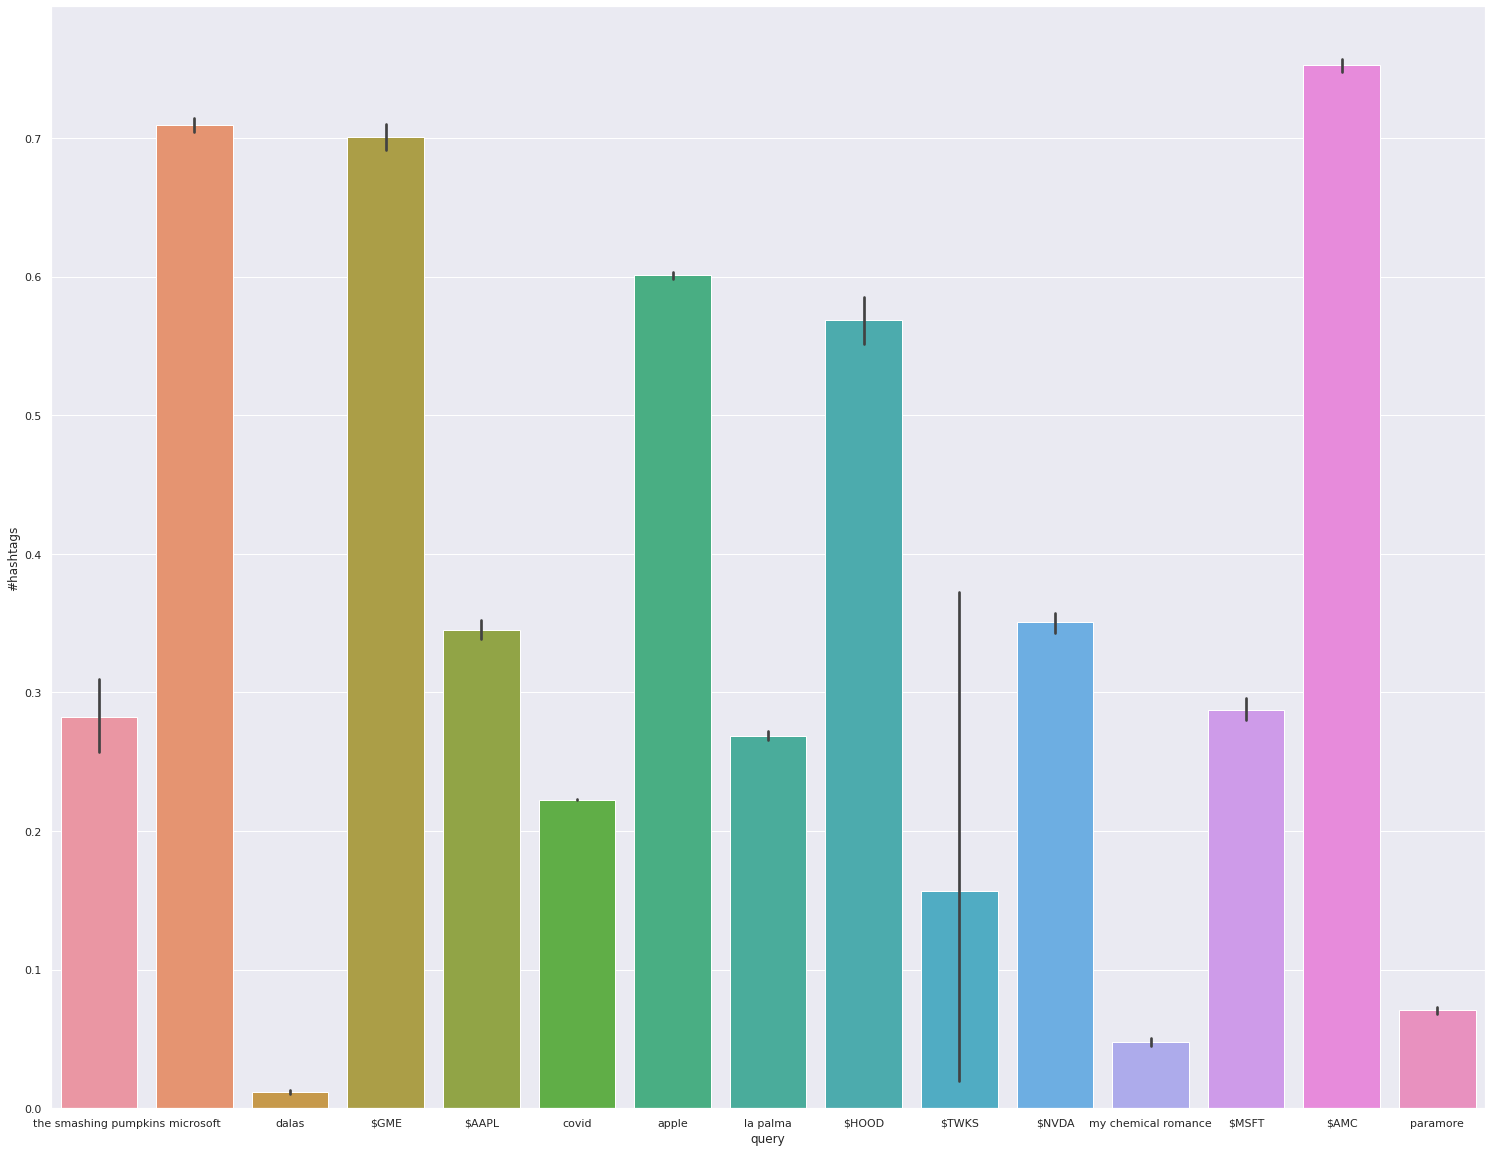

In [ ]:
sns.barplot(x="query", y="#hashtags", data=twiiter_raw_full_dataframe)

Average number of links per entity

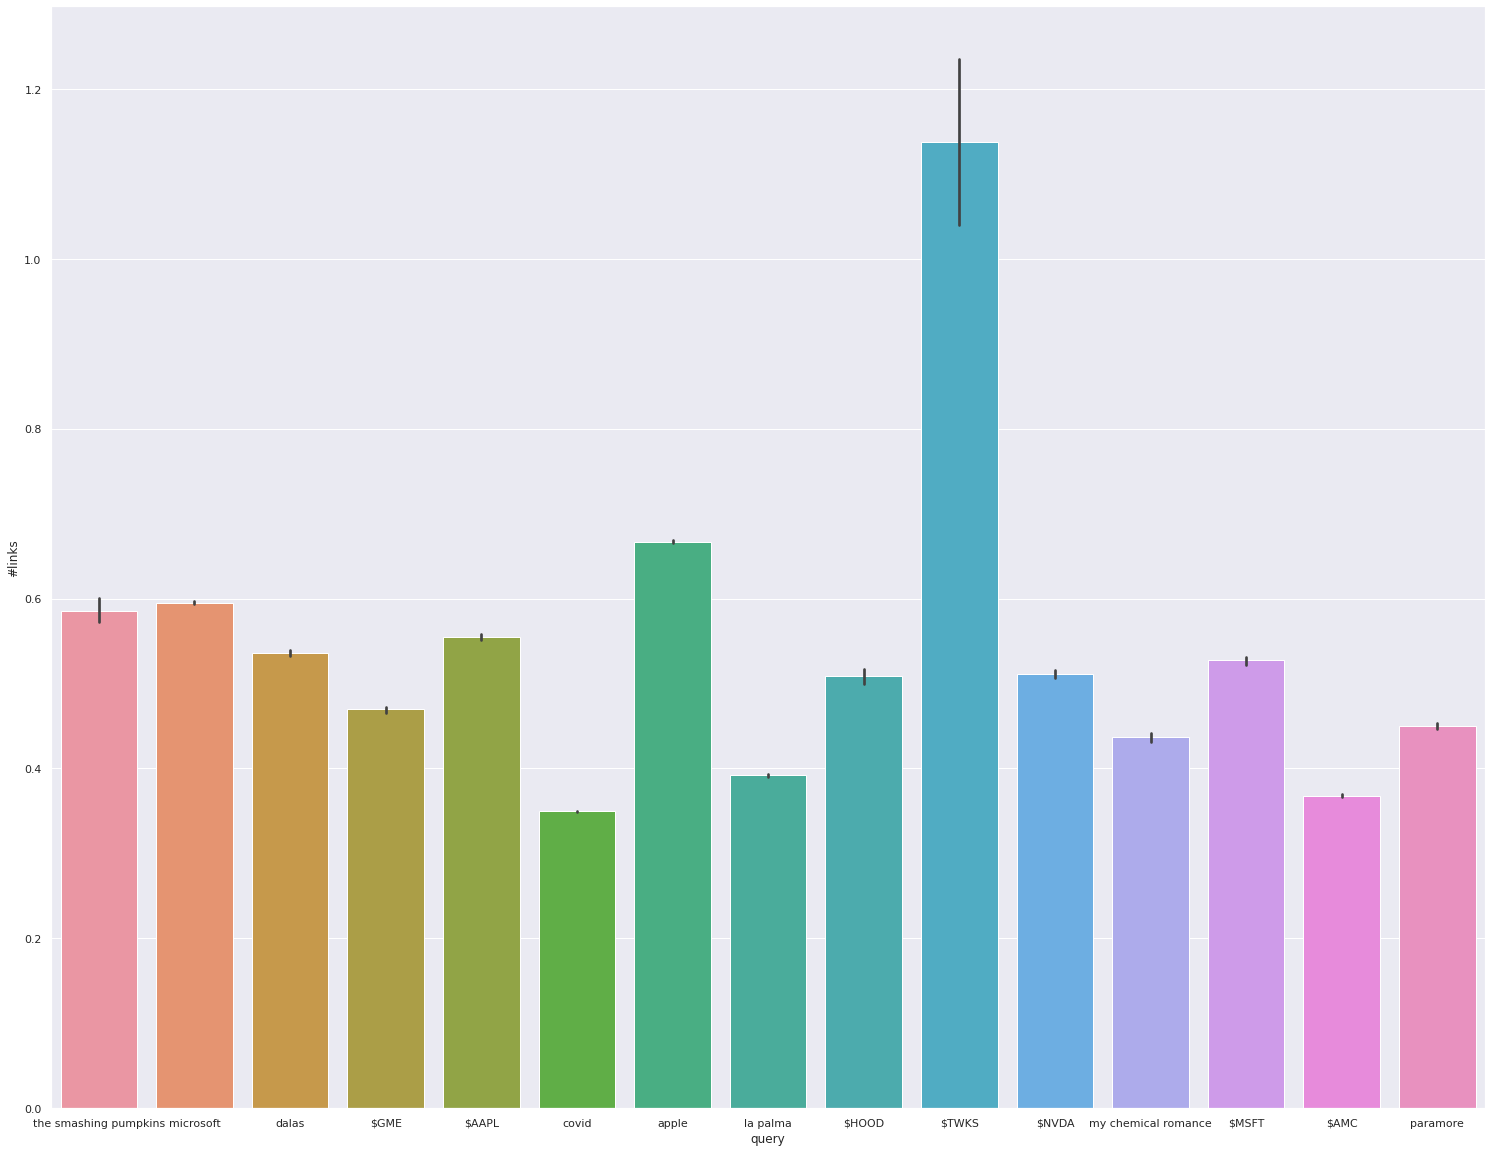

In [ ]:
sns.barplot(x="query", y="#links", data=twiiter_raw_full_dataframe)

Count of tweets that are retweets per entity

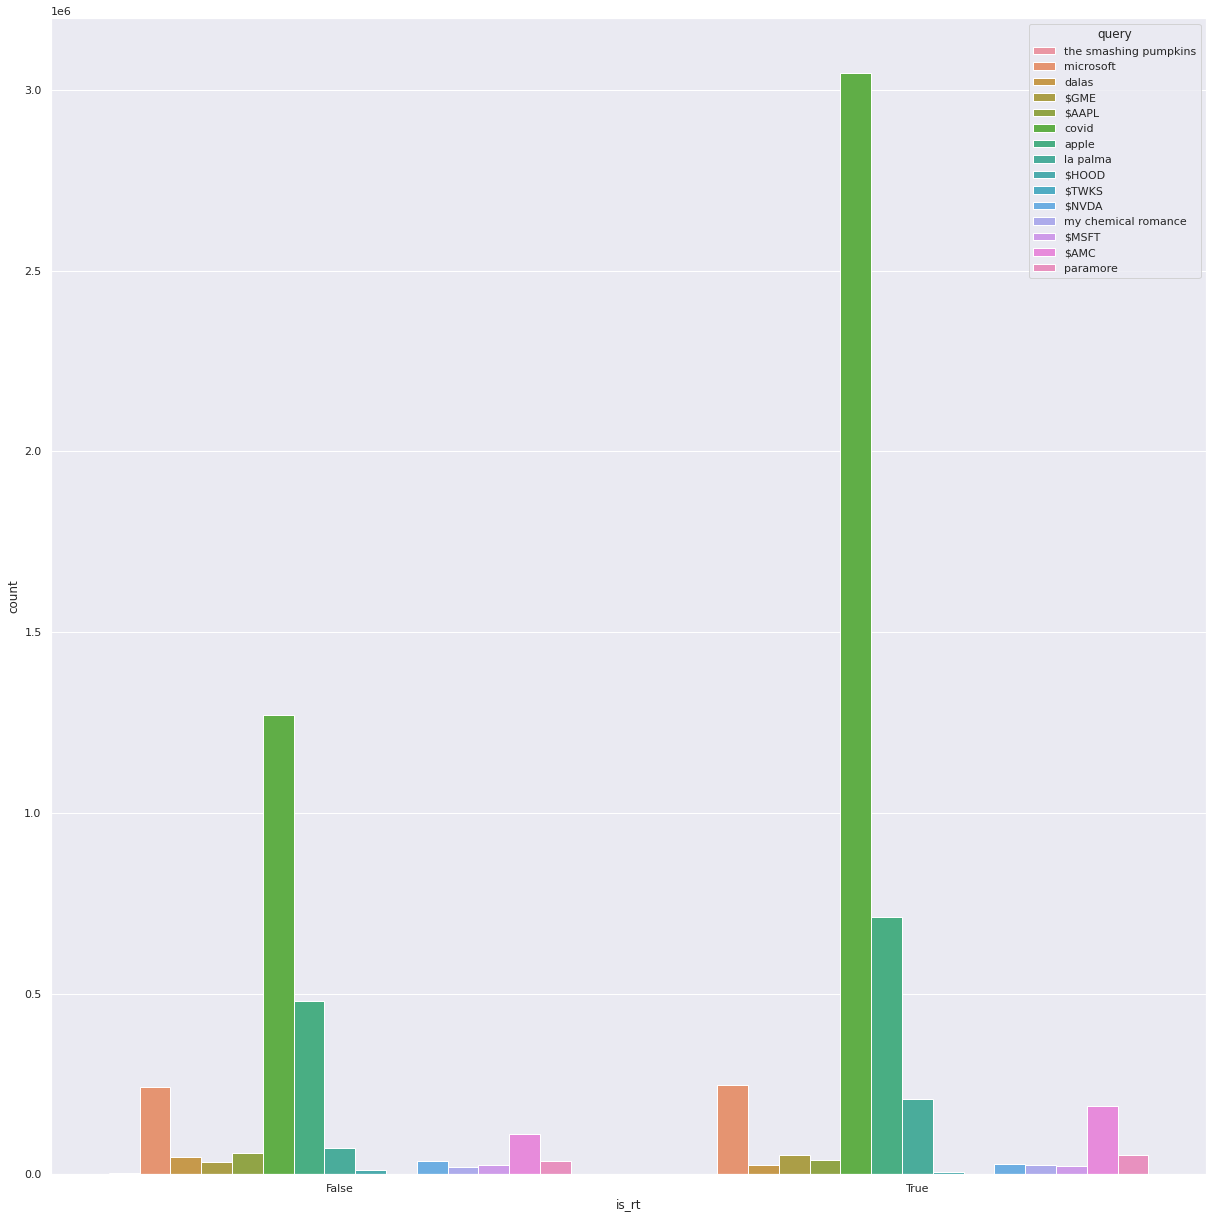

In [ ]:
sns.set(rc={'figure.figsize':(20.7,24.27)})
sns.countplot(x="is_rt", hue="query", data=twiiter_raw_full_dataframe)

Count of tweets per language

In [ ]:
sns.set(rc={'figure.figsize':(35.7,24.27)})

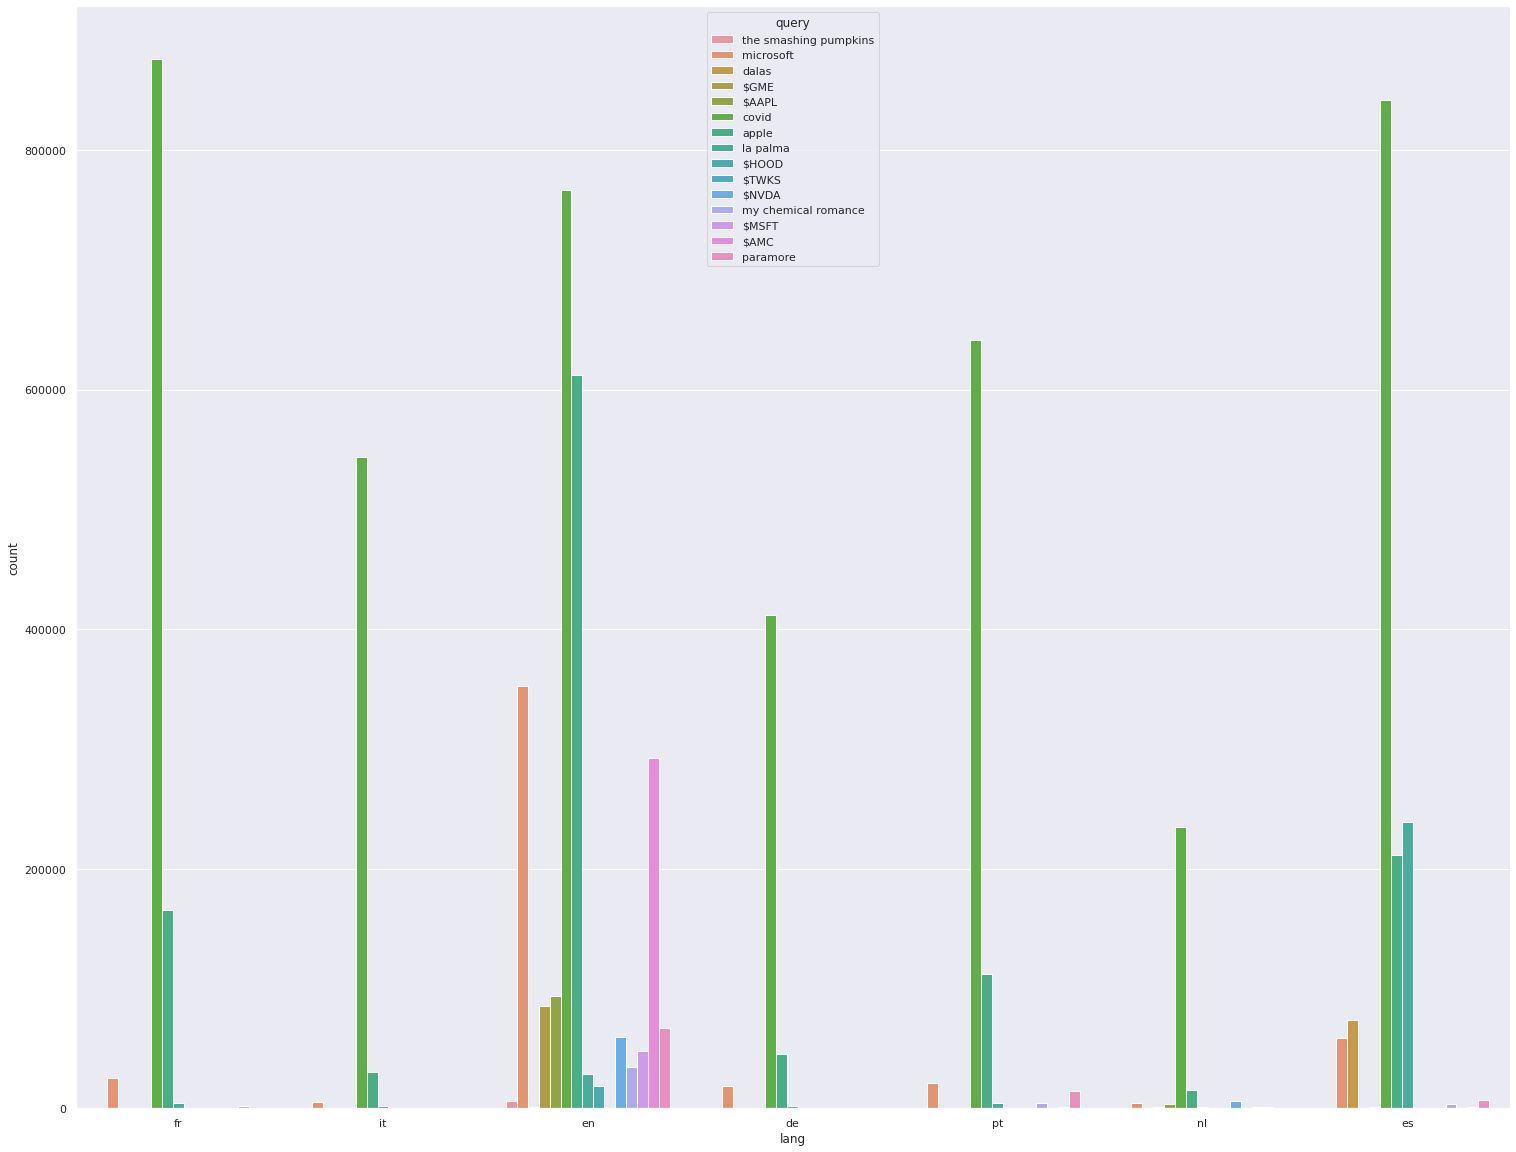

In [ ]:
sns.countplot(x="lang", hue="query", data=twiiter_raw_full_dataframe)

## Reddit dataset

First, it will be obtained the dataframes for each query.

In [ ]:
reddit_queries_dataset = dict_entity_dataframe['2022-01-14_full_reddit_dataset']

In [ ]:
dict_entity_dataframe['2022-01-14_full_reddit_dataset'][0]

('dalas',      Unnamed: 0  ...                                         user_url
 0             0  ...  http://www.reddit.com/user/Hot_Statistician8160
 1             1  ...          http://www.reddit.com/user/P3achMangoPi
 2             2  ...   http://www.reddit.com/user/Armoured_Sour_Cream
 3             3  ...           http://www.reddit.com/user/LundBiryani
 4             4  ...         http://www.reddit.com/user/Paddu_Padodha
 ..          ...  ...                                              ...
 695         695  ...            http://www.reddit.com/user/zhouse_org
 696         696  ...            http://www.reddit.com/user/zhouse_org
 697         697  ...             http://www.reddit.com/user/pizdec-n5
 698         698  ...          http://www.reddit.com/user/Mrshitpost14
 699         699  ...    http://www.reddit.com/user/ExplanationFew2569
 
 [700 rows x 11 columns])

**Number of ups per entity**

In [ ]:
# for each query, obtain a new dataframe with: 
  # Ups column
  # Comments column
  # query

columns_ups_comments = ["query", "lang", "sentiment", "#ups", "#comments"]
ups_comments_dataframe = pd.DataFrame(columns=columns_ups_comments)

dataframes_ups_comments_polarity_per_query = []
for tuple_query_dataframe in reddit_queries_dataset:

  query_dataframe_ups_comments = pd.DataFrame(columns=columns_ups_comments)

  query = tuple_query_dataframe[0]
  dataframe_query = tuple_query_dataframe[1]


  query_dataframe_ups_comments['#ups'] = dataframe_query['ups']
  query_dataframe_ups_comments['#comments'] = dataframe_query['comments']
  query_dataframe_ups_comments['sentiment'] = dataframe_query['sentiment']
  query_dataframe_ups_comments['lang'] = dataframe_query['lang']

  query_dataframe_ups_comments = query_dataframe_ups_comments.assign(query=query)
  dataframes_ups_comments_polarity_per_query.append(query_dataframe_ups_comments)

comments_ups_sentiment_dataframe_reddit = pd.concat(dataframes_ups_comments_polarity_per_query, ignore_index=True)

In [ ]:
comments_ups_sentiment_dataframe_reddit

,query,lang,sentiment,#ups,#comments
0,dalas,NaN,neutral,2,0
1,dalas,en,negative,5,2
2,dalas,hu,neutral,4,11
3,dalas,sl,neutral,11,2
4,dalas,en,positive,39,23
...,...,...,...,...,...
4195,la palma,es,neutral,1,0
4196,la palma,en,positive,1,3
4197,la palma,es,neutral,71,3
4198,la palma,es,neutral,9,0


**Ups plot**

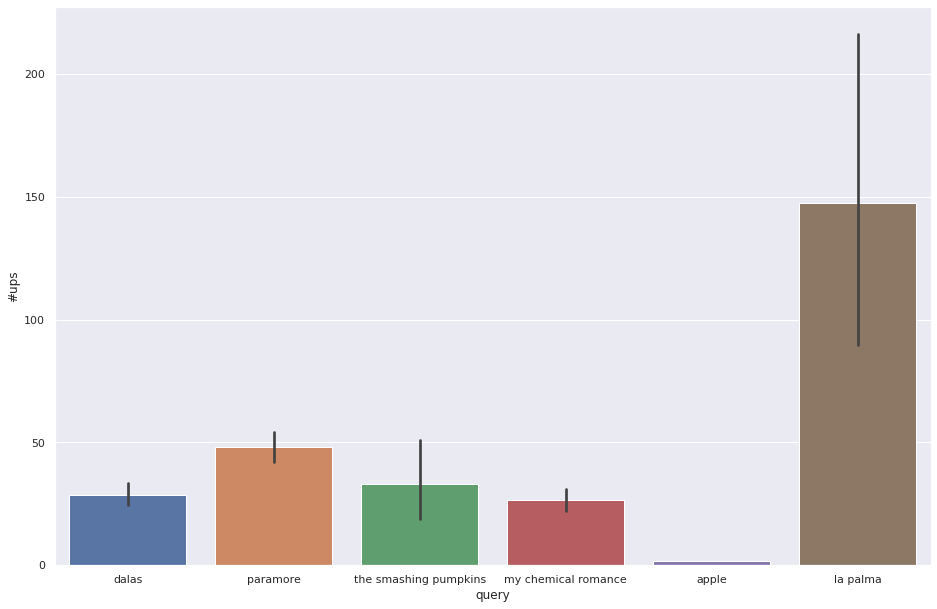

In [ ]:
sns.set(rc={'figure.figsize':(15.7,10.27)})
ax = sns.barplot(x="query", y="#ups", data=comments_ups_sentiment_dataframe_reddit)

**Comments plot**

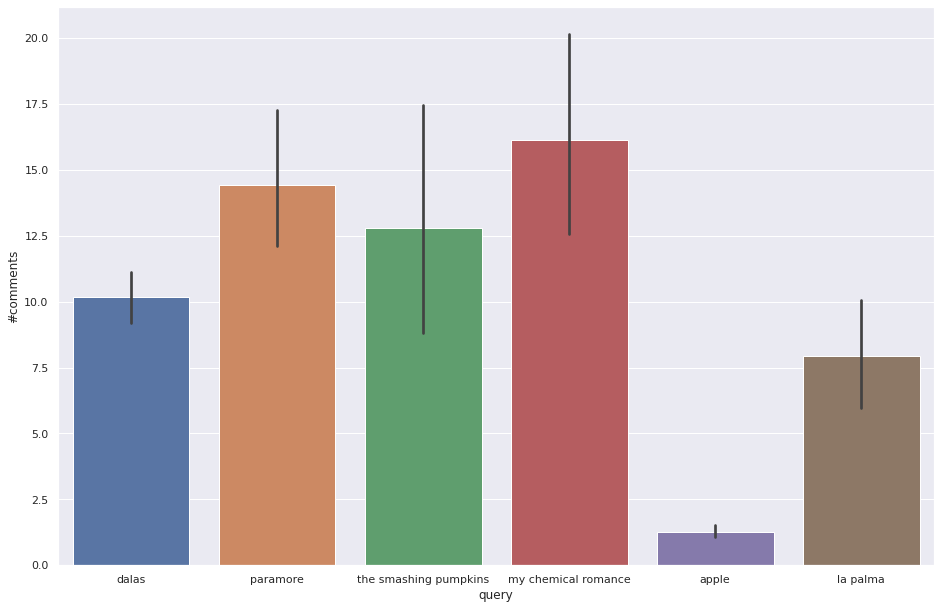

In [ ]:
#average number of comments per query.
ax = sns.barplot(x="query", y="#comments", data=comments_ups_sentiment_dataframe_reddit)

**Sentiment plot**

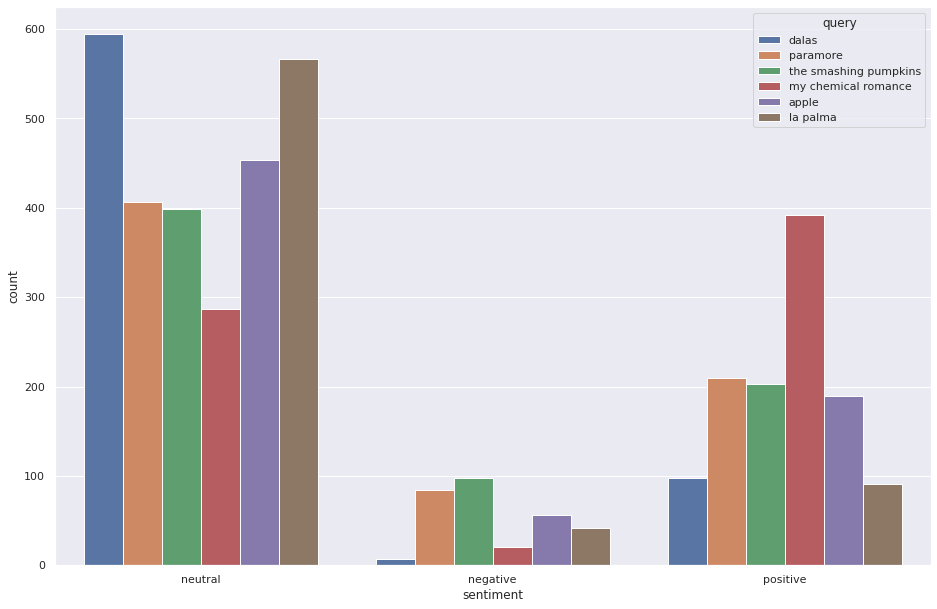

In [ ]:
ax = sns.countplot(x="sentiment", hue="query", data=comments_ups_sentiment_dataframe_reddit)

**Language plot**

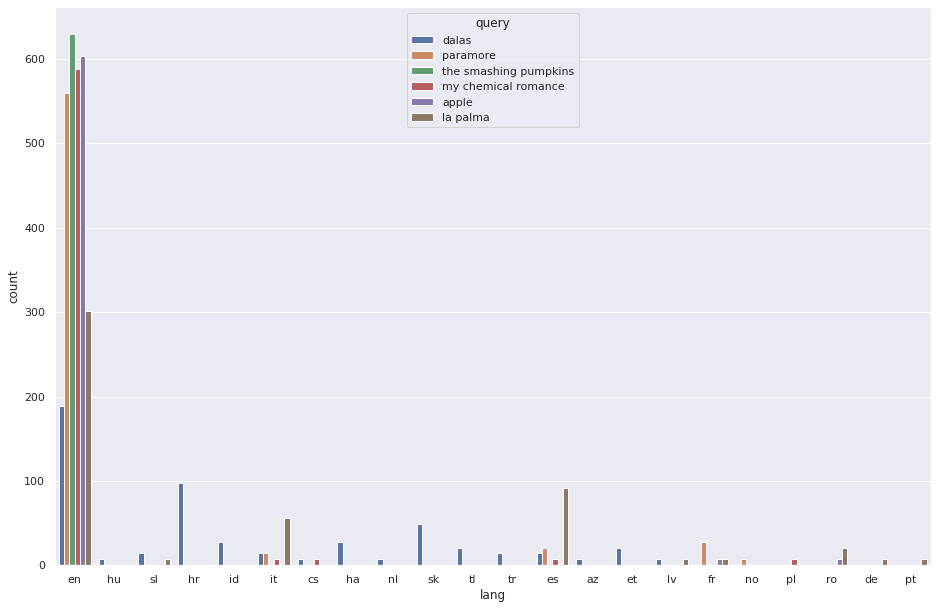

In [ ]:
ax = sns.countplot(x="lang", hue="query", data=comments_ups_sentiment_dataframe_reddit)

## Twingly dataset

In [ ]:
twingly_queries_dataset = dict_entity_dataframe['2022-01-11_full_twingly_dataset']

In [ ]:

columns_twingly_analysis = ["query", "lang", "#tags", "#links"]

twingly_analysis_dataframes = []
for tuple_query_dataframe in twingly_queries_dataset:

  dataframe_analysis = pd.DataFrame(columns=columns_twingly_analysis)
  dataframe_analysis
  query = tuple_query_dataframe[0]
  dataframe_query = tuple_query_dataframe[1]


  dataframe_analysis['#tags'] = dataframe_query['tags'].apply(lambda x: len(ast.literal_eval(x)))
  dataframe_analysis['#links'] = dataframe_query['links'].apply(lambda x: len(ast.literal_eval(x)))
  dataframe_analysis['lang'] = dataframe_query['language_code']

  dataframe_analysis = dataframe_analysis.assign(query=query)
  twingly_analysis_dataframes.append(dataframe_analysis)

final_dataframe_analysis = pd.concat(twingly_analysis_dataframes, ignore_index=True)

In [ ]:
final_dataframe_analysis

,query,lang,#tags,#links
0,dalas,es,1,3
1,dalas,es,0,3
2,dalas,es,0,3
3,dalas,es,6,1
4,dalas,es,1,3
...,...,...,...,...
18135,microsoft,nl,4,1
18136,microsoft,nl,0,2
18137,microsoft,nl,0,0
18138,microsoft,nl,0,0


In [ ]:
twingly_dataset.head(20)

**Plot the average number of tags per entity**

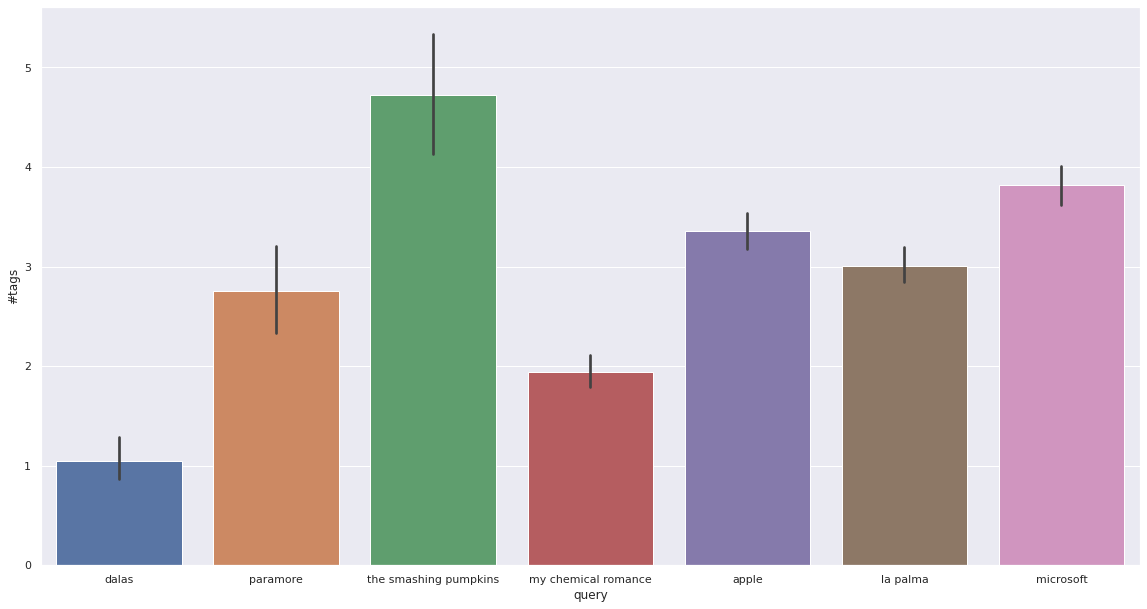

In [ ]:
sns.set(rc={'figure.figsize':(19.7,10.27)})
ax = sns.barplot(x="query", y="#tags", data=final_dataframe_analysis)

**Plot the average value of number of links per entity**

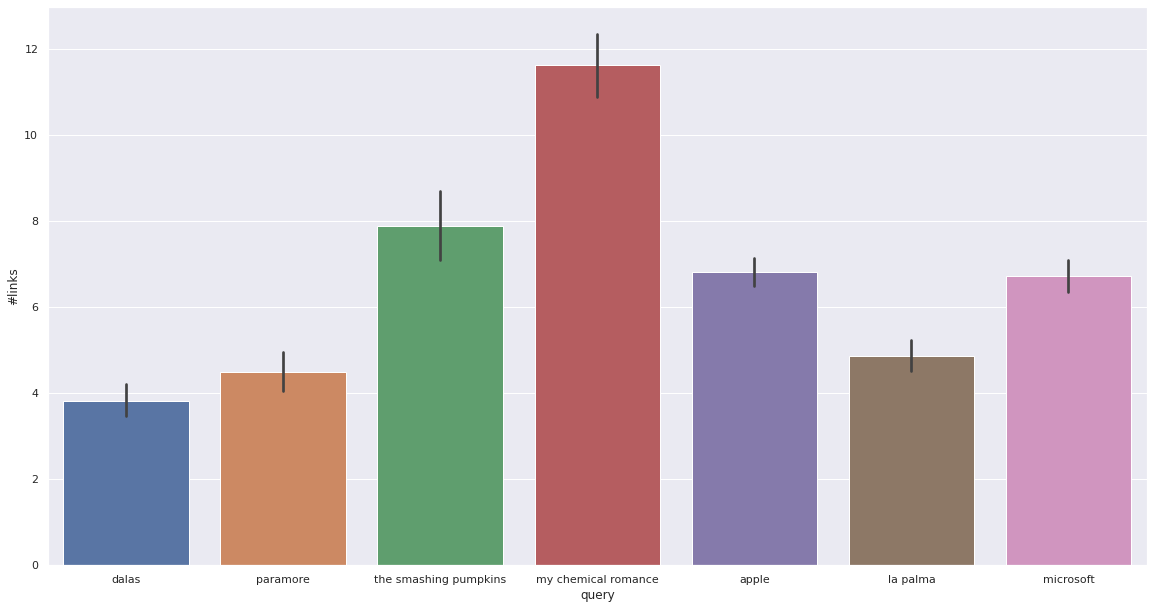

In [ ]:
ax = sns.barplot(x="query", y="#links", data=final_dataframe_analysis)

**Plot the count of posts of each language and query**

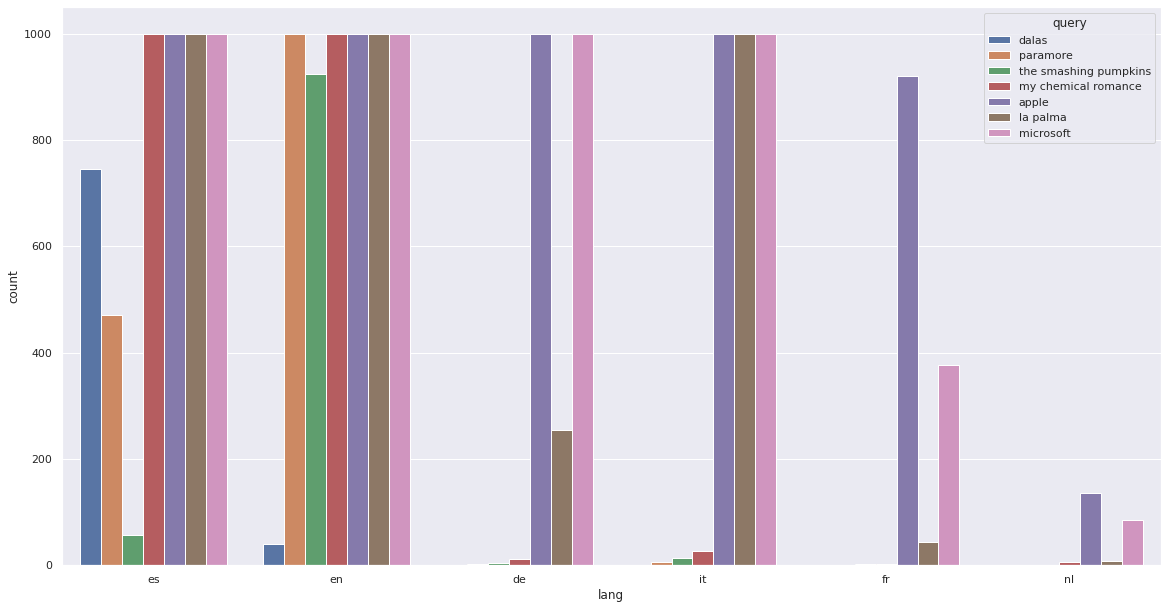

In [ ]:
ax = sns.countplot(x="lang", hue="query", data=final_dataframe_analysis)